# Data Transformation

A transformação de dados refere-se à modificação dos dados de forma a facilitar sua análise ou uso em modelos de machine learning. O pré-processamento e a transformação são etapas essenciais para garantir que os dados estejam no melhor formato possível para análises e modelagem.

Dados de qualidade resultam em modelos de machine learning mais eficientes, robustos e precisos. Sem um pré-processamento adequado, o desempenho dos modelos pode ser comprometido por inconsistências, variáveis mal formatadas ou valores faltantes.

Embora muitos desses aspectos tenham sido abordados na análise exploratória de dados (EDA), agora é o momento de formatar os dados matematicamente para uso nos algoritmos. Isso envolve tarefas como:

* Discretização: Transformar variáveis contínuas em categorias.
* Encoding: Converter variáveis categóricas em numéricas.
* Escalonamento: Ajustar a escala dos dados para garantir que todas as variáveis tenham a mesma influência no modelo.

# Imports

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.model_selection import train_test_split # Utilizado para separar dados de treino e teste
from sklearn.preprocessing import StandardScaler # Utilizado para fazer a normalização dos dados
from sklearn.preprocessing import MinMaxScaler # Utilizado para fazer a normalização dos dados
from sklearn.preprocessing import LabelEncoder # Utilizado para fazer o OneHotEncoding
from sklearn.linear_model import LinearRegression # Algoritmo de Regressão Linear
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import warnings
import json
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)

# Functions

In [2]:
def apply_discretization_map(df_new: pd.DataFrame, variable: str, discretization_map: dict, technique: str = 'equal_width', default_bin: int = -1) -> pd.DataFrame:
    """
    Aplica o mapeamento de discretização (bins ou thresholds) em novos dados.
    
    Parâmetros:
    - df_new: pd.DataFrame - DataFrame com os novos dados.
    - variable: str - Nome da variável a ser discretizada.
    - discretization_map: dict - Mapeamento com os pontos de corte (bins ou thresholds).
    - technique: str - Técnica usada para a discretização ('equal_width', 'equal_frequency', 'entropy').
    - default_bin: int - Valor padrão a ser atribuído para valores fora do mapeamento (default é -1).
    
    Retorno:
    - pd.DataFrame - DataFrame com a variável discretizada.
    """
    
    if technique in ['equal_width', 'equal_frequency']:
        bins = discretization_map[variable]
        
        # Aplicar a discretização e identificar valores fora dos bins
        df_new[f'{variable}_discretized'] = np.digitize(df_new[variable], bins=bins, right=True) - 1
        
        # Identificar valores fora do intervalo e atribuir um bin padrão (default_bin)
        out_of_bounds_mask = (df_new[variable] < bins[0]) | (df_new[variable] > bins[-1])
        
        if out_of_bounds_mask.any():
            print(f"Atenção: Valores de '{variable}' fora do mapeamento de discretização. "
                  f"Esses valores foram atribuídos ao bin {default_bin}.")
        
        df_new.loc[out_of_bounds_mask, f'{variable}_discretized'] = default_bin
    
    elif technique == 'entropy':
        thresholds = discretization_map['thresholds']
        
        # Aplicar a discretização
        df_new[f'{variable}_discretized'] = np.digitize(df_new[variable], bins=thresholds, right=True)
        
        # Identificar valores fora do intervalo e atribuir um bin padrão
        out_of_bounds_mask = (df_new[variable] < thresholds[0]) | (df_new[variable] > thresholds[-1])
        
        if out_of_bounds_mask.any():
            print(f"Atenção: Valores de '{variable}' fora dos thresholds de discretização. "
                  f"Esses valores foram atribuídos ao bin {default_bin}.")
        
        df_new.loc[out_of_bounds_mask, f'{variable}_discretized'] = default_bin
    
    else:
        raise ValueError("Técnica de discretização inválida. Escolha entre 'equal_width', 'equal_frequency' ou 'entropy'.")
    
    return df_new


def discretize_variable_with_map(df: pd.DataFrame, variable: str, target: str = None, technique: str = 'equal_width', bins: int = 5) -> tuple:
    """
    Discretiza uma variável contínua de um DataFrame e salva o mapeamento (bins ou thresholds).
    
    Parâmetros:
    - df: pd.DataFrame - DataFrame com os dados.
    - variable: str - Nome da coluna que será discretizada.
    - target: str - Nome da coluna da variável alvo (necessário para a técnica 'entropy').
    - technique: str - Técnica de discretização ('equal_width', 'equal_frequency', 'entropy').
    - bins: int - Número de intervalos desejados (não aplicável à técnica 'entropy').
    
    Retorno:
    - pd.DataFrame - DataFrame com a coluna discretizada.
    - dict - Mapeamento com os pontos de corte para reutilização em novos dados.
    """
    
    discretization_map = {}
    
    if technique == 'equal_width':
        # Discretização por amplitude (equal width)
        df[f'{variable}_discretized'], bin_edges = pd.cut(df[variable], bins=bins, labels=False, retbins=True)
        discretization_map[variable] = bin_edges  
    
    elif technique == 'equal_frequency':
        # Discretização por frequência (equal frequency)
        df[f'{variable}_discretized'], quantile_edges = pd.qcut(df[variable], q=bins, labels=False, retbins=True)
        discretization_map[variable] = quantile_edges  
    
    elif technique == 'entropy':
        # Discretização supervisionada baseada em entropia (árvore de decisão)
        if target is None:
            raise ValueError("A variável alvo ('target') deve ser especificada para a técnica 'entropy'.")
        tree = DecisionTreeClassifier(criterion='entropy', max_leaf_nodes=bins)
        tree.fit(df[[variable]], df[target])
        thresholds = tree.tree_.threshold[tree.tree_.threshold != -2]
        df[f'{variable}_discretized'] = np.digitize(df[variable], bins=thresholds, right=True)
        discretization_map[variable] = thresholds  
    
    else:
        raise ValueError("Técnica de discretização inválida. Escolha entre 'equal_width', 'equal_frequency' ou 'entropy'.")
    
    return df, discretization_map



def one_hot_encode(df: pd.DataFrame, column: str) -> tuple:
    """
    Realiza One-Hot Encoding de uma coluna categórica em um DataFrame e retorna o DataFrame com as colunas dummies,
    juntamente com o mapeamento das categorias para as colunas geradas.
    
    Parâmetros:
    - df: pd.DataFrame - DataFrame que contém a coluna a ser codificada.
    - column: str - Nome da coluna a ser codificada.
    
    Retorna:
    - tuple: (DataFrame codificado, dicionário com o mapeamento das categorias para colunas).
    """
    df_encoded = pd.get_dummies(df, columns=[column], drop_first=True)
    
    # Mapeamento das categorias para colunas
    categories = df[column].unique()
    encoder_map = {category: f"{column}_{category}" for category in categories if f"{column}_{category}" in df_encoded.columns}
    
    return df_encoded, encoder_map



def label_encoder(df: pd.DataFrame, variable: str) -> tuple:
    """
    Aplica Label Encoding a uma variável categórica em um DataFrame.
    
    Parâmetros:
    - df: pd.DataFrame - DataFrame que contém a coluna a ser codificada.
    - variable: str - Nome da coluna a ser codificada.
    
    Retorna:
    - tuple: (DataFrame com a coluna codificada, dicionário de mapeamento das categorias para valores numéricos).
    """
    categories = df[variable].unique()
    
    # Criar mapeamento das categorias para números
    label_mapping = {category: idx for idx, category in enumerate(categories)}
    
    # Aplicar o mapeamento diretamente na coluna
    df[variable] = df[variable].map(label_mapping)
    
    return df, label_mapping


def apply_encoding(df: pd.DataFrame, column: str, encoding_map: dict, encoding_type: str, default_value: int = None) -> pd.DataFrame:
    """
    Aplica One-Hot Encoding ou Label Encoding com base no tipo de codificação especificado.
    
    Parâmetros:
    - df: pd.DataFrame - DataFrame que contém a coluna a ser codificada.
    - column: str - Nome da coluna a ser codificada.
    - encoding_map: dict - Dicionário com o mapeamento de codificação (categoria para coluna ou valor).
    - encoding_type: str - Tipo de codificação ('onehot' ou 'label').
    - default_value: int - Valor padrão a ser atribuído para valores não mapeados no caso do Label Encoding (default: None).
    
    Retorna:
    - pd.DataFrame - DataFrame com a coluna codificada.
    """
    if encoding_type == 'label':
        # Definir valor padrão se não fornecido
        if default_value is None:
            default_value = 0

        # Aplicar o mapeamento, atribuindo default_value para valores não mapeados
        df[column] = df[column].map(encoding_map).fillna(default_value).astype(int)
    
    elif encoding_type == 'onehot':
        # Criar todas as colunas necessárias com valor 0 inicialmente
        for category, map_col in encoding_map.items():
            df[map_col] = 0  # Inicializar com 0
        
        # Garantir que o mapeamento fornecido está correto
        for category, map_col in encoding_map.items():
            if category in df[column].unique():
                # Atualizar os valores da coluna correspondente
                df[map_col] = (df[column] == category).astype(int)

        df = df.drop(columns=column)
    else:
        raise ValueError("Tipo de codificação inválido. Escolha 'onehot' ou 'label'.")
   
    return df


## Load Data

Aqui é carregado os dados já pre-processados e realizados o tratamento de valores faltantes e tratamento de _outliers_.

In [3]:
df = pd.read_csv("../datasets/dados_credito_pos_eda.csv").drop(columns='SCORE_classification')
df.head()

,UF,IDADE,ESCOLARIDADE,ESTADO_CIVIL,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TEMPO_ULTIMO_EMPREGO_MESES,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE,SCORE_scaled,VLM_IMOVEIS,RENDA_TOTAL,VM_VEICULOS
0,SP,19,Superior Cursando,Solteiro,0,Não,0,0,Não,0,8,Sim,1800.00,0,0,12.00,850.00,0.00,1800.00,0.00
1,MG,23,Superior Completo,Solteiro,1,Não,0,0,Não,0,9,Não,4800.00,1,50000,18.00,811.63,0.00,0.00,50000.00
2,SC,25,Segundo Grau Completo,Casado,0,Sim,1,220000,Não,0,18,Sim,2200.00,2,30000,23.00,779.65,220000.00,2200.00,15000.00
3,PR,27,Superior Cursando,Casado,1,Sim,0,0,Não,0,22,Não,3900.00,0,0,28.67,743.41,0.00,0.00,0.00
4,RJ,28,Superior Completo,Divorciado,2,Não,1,370000,Não,0,30,Sim,8287.16,1,35000,34.17,708.24,370000.00,8287.16,35000.00


## Train Test Split

Dividir os dados entre treino e teste antes de aplicar o pré-processamento garante que o modelo seja treinado e avaliado de forma justa. Isso evita o vazamento de dados, permitindo que o conjunto de teste simule corretamente novos dados reais.

Esse processo é fundamental para preservar a capacidade do modelo de generalizar adequadamente, que é um dos principais objetivos no aprendizado de máquina.

Como o conjunto de teste será utilizado para avaliar a performance do modelo, ele deve representar novas entradas para a _pipeline_ de dados. Portanto, é imprescindível dividir os dados antes de aplicar transformações como normalização, padronização ou aplicação de qualquer outra tarefa e/ou técnica que dependa de ajustes baseados no conjunto de treinamento.

Isso assegura que os ajustes feitos no pré-processamento reflitam apenas o comportamento dos dados de treino, mantendo o conjunto de teste imparcial.

_______________________________________________________________________________________________________________________________
Existem diversas técnicas para dividir os dados entre treinamento e teste quando se prepara um modelo de machine learning.

Cada técnica tem suas vantagens dependendo da natureza dos dados e do problema. Algumas das técnicas mais comuns são:

* **_Treino/Teste Split Simples_**

    Consiste em dividir os dados em duas partes, uma para treinamento e outra para teste.

    80% dos dados para treinamento e 20% para teste. Ou 70/30.
    
    Simples e rápida de implementar. X O desempenho pode variar muito dependendo da divisão específica.

* **_k-Fold Cross Validation_**
    
    Os dados são divididos em k partes iguais. O modelo é treinado em k-1 partes e testado na parte restante. Isso é repetido k vezes, com cada parte sendo usada uma vez para teste.

    Se k=5, os dados são divididos em 5 partes, e o modelo é treinado e testado 5 vezes, cada vez com uma parte diferente como teste.

    Reduz a variação dos resultados, fornecendo uma avaliação mais estável do desempenho do modelo. X Mais lento, pois o modelo é treinado e avaliado várias vezes.

* **_Stratified_**

    Garante que a distibução de treino e de teste tenha a mesma distribuição de classes.
    
    Se você tiver 70% de uma classe "A" e 30% de outra "B", essa proporção será mantida na divisão. Isto é, no conjunto de treino terão 70% da classe "A" e 30% da classe "B". Bem como nos dados de teste, terão a mesma porporção das classes "A" e "B".
    
    Evita problemas com desbalanceamento de classes, especialmente útil em classificação. X Pode ser mais complexo de implementar em certos cenários.
______________________________________________________________________________________________________________________________________



> Neste projeto será utilizado uma divisão simples de 80% dos dados para treinamento e 20% para teste.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["SCORE"]), df['SCORE'], test_size = 0.2, random_state = 42)

# Preprocessing

As técnicas de pré-processamento de dados devem ser aplicadas após a divisão dos conjuntos de treino e teste. Isso garante que as transformações sejam ajustadas apenas com base nos dados de treino, simulando uma situação mais realista ao aplicar o modelo em novos dados.

É importante salvar os mapeamentos das transformações realizadas, como codificações ou escalonamentos, para que essas mesmas transformações sejam aplicadas corretamente aos dados de teste. Isso assegura a consistência do processo e evita distorções nos resultados.

## Discretização

A discretização de dados é uma técnica que transforma variáveis contínuas em categorias, dividindo os valores em intervalos ou faixas. Essa abordagem é útil em diversas situações, como:

* Redução da complexidade: Facilita a análise ao converter variáveis contínuas em categorias.
    
* Compatibilidade com modelos: Alguns algoritmos, como os baseados em árvores de decisão, funcionam melhor com variáveis discretas.
    
* Melhor desempenho: Ao reduzir o ruído em dados contínuos, a discretização pode melhorar a precisão dos modelos.

* Facilidade de interpretação: Cria faixas ou grupos que tornam a análise de dados mais acessível.

____________________________________________________________________________________________________________________________________
__Principais Técnicas de Discretização:__


* _Discretização por Frequência (Equal Frequency)_:

    Divide os dados em intervalos que contêm o mesmo número de observações.
    Exemplo: Se houver 100 amostras e 5 intervalos, cada intervalo terá 20 observações.
    
* _Discretização por Amplitude (Equal Width)_:

    Divide os valores contínuos em subintervalos de largura fixa.
    Exemplo: Se os dados variam de 0 a 100 e são criados 5 intervalos, cada um terá uma largura de 20 (0-20, 21-40, etc.).
    
* _Discretização Baseada em K-means_:

    Usa o algoritmo K-means para agrupar os dados em categorias com base na similaridade.
    
* _Discretização Supervisionada (Entropia)_:

    Maximiza a relação entre a variável contínua e a variável alvo, retendo o máximo de informação.
    Técnicas como ChiMerge e Decision Trees podem ser usadas para determinar os melhores pontos de divisão.
       
____________________________________________________________________________________________________________________________________


> [!NOTE]
> Foram discretizadas usando a técnica de Equal Frequency, garantindo que cada intervalo contenha um número equivalente de observações.

* [ 'IDADE', 'TEMPO_ULTIMO_EMPREGO_MESES' ]

> [!ATENTION]
Atenção, pode ocorrer que ao interir dados novos, eles possuírem valores que não estão no range de discrtização, por isso, vamos marcar esse valor como -1. Que caso ocorra, precisa ser verificado o que ocorreu e dar a manutenção no modelo desenvolvido.

In [5]:
X_train, map_age = discretize_variable_with_map(X_train, 'IDADE', 'SCORE', technique='equal_frequency', bins=5)
# aply in test data 
X_test = apply_discretization_map(X_test, 'IDADE', map_age, 'equal_frequency')
len(X_train.columns) , len(X_test.columns)

(20, 20)

In [6]:
X_train, map_range_employer = discretize_variable_with_map(X_train, 'TEMPO_ULTIMO_EMPREGO_MESES', 'SCORE', technique='equal_frequency', bins=5)
X_test = apply_discretization_map(X_test, 'TEMPO_ULTIMO_EMPREGO_MESES', map_range_employer, 'equal_frequency')
len(X_train.columns) , len(X_test.columns)

(21, 21)

In [7]:
X_train = X_train.drop(columns=['IDADE', 'TEMPO_ULTIMO_EMPREGO_MESES'])
X_test = X_test.drop(columns=['IDADE', 'TEMPO_ULTIMO_EMPREGO_MESES'])
X_train.shape, X_test.shape

((8380, 19), (2096, 19))

# Encoding

O _encoding_ é uma técnica essencial de pré-processamento que converte variáveis categóricas (qualitativas) em um formato numérico (quantitativas). Isso permite que algoritmos de aprendizado de máquina realizem cálculos matemáticos. A maioria desses algoritmos, como redes neurais e regressões, trabalha exclusivamente com números e não consegue processar diretamente dados categóricos. 

______________________________________________________________________________________________________________________________________


Principais Tipos de Encoding

* **_One Hot Encoding_**

    O _One Hot Encoding_ é uma das técnicas mais utilizadas para lidar com variáveis categóricas, especialmente em problemas de aprendizado supervisionado. Ele transforma cada categoria em uma nova coluna binária (0 ou 1), representando a presença ou ausência dessa categoria em cada instância dos dados.
    
    🎯 Por que usar One Hot Encoding?
    
    - Evitar ordens implícitas

        Quando categorias são substituídas por números inteiros (ex.: "Vermelho" = 1, "Verde" = 2, "Azul" = 3), pode-se induzir uma ordem entre as categorias que não reflete a realidade. O One Hot Encoding remove essa ambiguidade ao criar variáveis binárias para cada categoria, evitando que o modelo interprete relações inexistentes.

    - Benefícios para algoritmos baseados em distâncias
        
        Algoritmos como K-NN e SVM, que utilizam cálculos de distância, se beneficiam de variáveis em formato binário. Usar números inteiros poderia criar distorções na interpretação da similaridade entre categorias.
        
    - Utilização em problemas supervisionados
        
        O One Hot Encoding é amplamente usado quando os modelos precisam aprender as relações entre variáveis categóricas e um alvo, fornecendo uma representação clara e não enviesada.
    
    ❌ Quando evitar o One Hot Encoding?
        
    - Variáveis com muitas categorias
        
        Se uma variável categórica possui inúmeras categorias (por exemplo, "Cidade" com centenas de valores), o One Hot Encoding pode gerar uma quantidade excessiva de colunas, aumentando a dimensionalidade do dataset. Isso pode prejudicar o desempenho do modelo e dificultar o treinamento.
    
    - Modelos que lidam bem com categorias
    
       Algoritmos como árvores de decisão, random forests e gradient boosting lidam diretamente com variáveis categóricas sem a necessidade de One Hot Encoding. Nesses casos, aplicar a técnica pode ser desnecessário e menos eficiente.


* **_Label Encoding_**

    O _Label Encoding_ substitui as categorias por números inteiros. É uma solução mais simples do que o _One Hot Encoding_, onde cada categoria recebe um valor numérico exclusivo (ex.: "Masculino" = 0, "Feminino" = 1).

    🎯 Quando utilizar?
    
    O Label Encoding é mais eficiente em dois cenários principais:
    
    - Variáveis ordinais
       
       Quando se lida com variáveis categóricas que possuem uma ordem intrínseca, como "Baixo", "Médio" e "Alto". Nesse caso, a atribuição de números inteiros faz sentido e reflete a relação natural entre as categorias, permitindo que o modelo capture essa hierarquia.

    - Variáveis binárias
    
       Quando se trabalha com variáveis categóricas que possuem apenas duas categorias, como "Sim" e "Não", ou "Masculino" e "Feminino". Nesse caso, o Label Encoding é apropriado porque a relação entre as duas categorias é clara e não introduz ambiguidade ao atribuir valores como 0 e 1.

    ❌ Cuidado com as ordens implícitas!

    O principal risco do _Label Encoding_ é quando ele é aplicado a variáveis nominais (sem ordem).
    
    A atribuição de números inteiros pode induzir uma relação de magnitude que não existe.
    
    * **Exemplo**:
    
        Suponha que o _label encoder_ atribui os valores de 0, 2 e 3 da seguinte forma:
    
        { "Cão" = 0, "Gato" = 2 e "Pássaro" = 3}   
    
       Nesse caso, o algoritmo pode erroneamente interpretar que "Gato" está mais próximo de "Pássaro" do que de "Cão". Essa interpretação é problemática porque, matematicamente, a distância entre "Gato" e "Pássaro" é apenas 1 unidade, enquanto a distância entre "Gato" e "Cão" é de 2 unidades.
       
       Esse tipo de relação não reflete a realidade, pois não existe uma ordem ou hierarquia natural entre essas categorias. Portanto, ao utilizar _Label Encoding_ para variáveis nominais, é fundamental estar atento a essa armadilha, pois o modelo pode inferir conexões que não existem.
_____________________________________________________________________________________________________________________________________
> [!NOTE]
> Para este projeto foi aplicado as seguintes transformações:

* One Hot Encoder: [ 'UF', 'ESATDO_CIVIL' ]

* Label Encoder: [ 'ESCOLARIDADE', 'CASA_PROPRIA', 'OUTRA_RENDA', 'TRABALHANDO_ATUALMENTE']

In [8]:
X_train, encoder_uf = one_hot_encode(X_train, 'UF')
X_test = apply_encoding(X_test, 'UF', encoder_uf, 'onehot')
X_train.shape, X_test.shape

((8380, 22), (2096, 22))

In [9]:
X_train, encoder_estado_civil = one_hot_encode(X_train, 'ESTADO_CIVIL')
X_test = apply_encoding(X_test, 'ESTADO_CIVIL', encoder_estado_civil, 'onehot')
X_train.shape, X_test.shape

((8380, 24), (2096, 24))

In [10]:
X_train, encoder_escolaridade = label_encoder(X_train, 'ESCOLARIDADE')
X_test = apply_encoding(X_test, 'ESCOLARIDADE', encoder_escolaridade,'label')
X_train.shape, X_test.shape

((8380, 24), (2096, 24))

In [11]:
X_train, encoder_casa_propria = label_encoder(X_train, 'CASA_PROPRIA')
X_test = apply_encoding(X_test, 'CASA_PROPRIA', encoder_casa_propria,'label')
X_train.shape, X_test.shape

((8380, 24), (2096, 24))

In [12]:
X_train, encoder_outra_renda = label_encoder(X_train, 'OUTRA_RENDA')
X_test = apply_encoding(X_test, 'OUTRA_RENDA', encoder_outra_renda, 'label')
X_train.shape, X_test.shape

((8380, 24), (2096, 24))

In [13]:
X_train, encoder_trabalhando_atualmente = label_encoder(X_train, 'TRABALHANDO_ATUALMENTE')
X_test = apply_encoding(X_test, 'TRABALHANDO_ATUALMENTE', encoder_trabalhando_atualmente, 'label')
X_train.shape, X_test.shape

((8380, 24), (2096, 24))

## Scale

Deixar os dados na mesma escala refere-se ao processo de ajustar os valores numéricos de diferentes variáveis para estarem no mesmo intervalo ou faixa, ou tenham uma variação semelhante. Isso é importante porque alguns algoritmos de Aprendizado de Máquina são sensíveis à escala dos dados e podem se beneficiar de variáveis que estão padronizadas ou normalizadas.
_______________________________________________________________________________________________________________________
**Padronização**

A padronização (ou standardization) transforma os dados para terem média 0 e desvio padrão 1. Isso significa que os valores ajustados de cada variável estarão centrados em torno da média e medidos em termos de unidades de desvio padrão.

_______________________________________________________________________________________________________________________
**Normalização**

A normalização (ou min-max scaling) transforma os dados para que todos os valores estejam em um intervalo específico, normalmente entre 0 e 1. Isso é feito ajustando a escala dos valores da variável.

_________________________________________________________________________________________________________________________
<p align="center"><strong>TABELA RESUMO<strong></p>

_________________________________________________________________________________________________________________________

| Característica             | Padronização                                           | Normalização                                        |
|----------------------------|-------------------------------------------------------|----------------------------------------------------|
| Definição                   | Ajusta os dados para terem média 0 e desvio padrão 1.  | Ajusta os dados para estarem em um intervalo específico (geralmente de 0 a 1). |
| Quando aplicar              | Útil para algoritmos que assumem uma distribuição gaussiana (normal), como regressão linear, SVM, KNN. | Útil para algoritmos que utilizam gradientes, como redes neurais e algoritmos de otimização. |
| Impacto                     | Algoritmos que dependem de medidas de distância ou gradientes se beneficiam da padronização. | Evita que variáveis com diferentes escalas afetem o processo de treinamento.  |
| Exemplos de uso             | Regressão linear, K-Nearest Neighbors (KNN), Support Vector Machines (SVM). | Redes neurais, k-means, regressão logística.        |


________________________________________________________________________________________________________________________________
> [!NOTE]

> Neste projeto foram aplicados a escala utilizando a padronização (standard) para todas as colunas numéricas.

In [14]:
def scale_data(df, columns, method):
    """
    Função que normaliza ou padroniza colunas específicas de um DataFrame usando MinMaxScaler ou StandardScaler
    do scikit-learn, mantendo as demais colunas intactas.
    
    Parâmetros:
    - df: DataFrame com os dados
    - columns: lista de colunas a serem escaladas
    - method: método de escalonamento ('minmax' ou 'standard')
    
    Retorna:
    - df_scaled: DataFrame completo com as colunas especificadas escaladas
    - scaler: objeto scaler (MinMaxScaler ou StandardScaler) com os parâmetros salvos
    """
    df_scaled = df.copy()
    
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Método inválido. Escolha entre 'minmax' ou 'standard'.")

    df_scaled[columns] = scaler.fit_transform(df[columns])
    
    return df_scaled, scaler

def apply_scaling(df_new, columns, scaler):
    """
    Aplica a normalização ou padronização a novas colunas específicas usando o scaler já ajustado,
    mantendo as demais colunas intactas.
    
    Parâmetros:
    - df_new: DataFrame com os novos dados
    - columns: lista de colunas a serem escaladas
    - scaler: objeto scaler (MinMaxScaler ou StandardScaler) ajustado com os dados originais
    
    Retorna:
    - df_new_scaled: DataFrame completo com as colunas especificadas escaladas
    """

    df_new_scaled = df_new.copy()

    df_new_scaled[columns] = scaler.transform(df_new[columns])
    
    return df_new_scaled

In [15]:
num_cols = X_train.select_dtypes(include=['int', 'float']).columns.to_list()
num_cols 

['ESCOLARIDADE',
 'QT_FILHOS',
 'CASA_PROPRIA',
 'QT_IMOVEIS',
 'VL_IMOVEIS',
 'OUTRA_RENDA',
 'OUTRA_RENDA_VALOR',
 'TRABALHANDO_ATUALMENTE',
 'ULTIMO_SALARIO',
 'QT_CARROS',
 'VALOR_TABELA_CARROS',
 'SCORE_scaled',
 'VLM_IMOVEIS',
 'RENDA_TOTAL',
 'VM_VEICULOS',
 'IDADE_discretized',
 'TEMPO_ULTIMO_EMPREGO_MESES_discretized']

In [16]:
X_train_scaled, scaler_x = scale_data(X_train, num_cols, method='standard')
X_test_scaled = apply_scaling(X_test, num_cols, scaler_x)
X_train_scaled.describe()

,ESCOLARIDADE,QT_FILHOS,CASA_PROPRIA,QT_IMOVEIS,VL_IMOVEIS,OUTRA_RENDA,OUTRA_RENDA_VALOR,TRABALHANDO_ATUALMENTE,ULTIMO_SALARIO,QT_CARROS,VALOR_TABELA_CARROS,SCORE_scaled,VLM_IMOVEIS,RENDA_TOTAL,VM_VEICULOS,IDADE_discretized,TEMPO_ULTIMO_EMPREGO_MESES_discretized
count,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00,8380.00
mean,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.18,-1.14,-0.92,-0.88,-0.89,-0.51,-0.50,-0.80,-1.11,-1.16,-0.86,-1.73,-1.03,-0.83,-0.84,-1.38,-1.38
25%,-1.18,-1.14,-0.92,-0.88,-0.89,-0.51,-0.50,-0.80,-0.75,-1.16,-0.86,-0.80,-1.03,-0.83,-0.84,-0.64,-0.66
50%,0.06,-0.11,-0.92,0.17,-0.19,-0.51,-0.50,-0.80,-0.37,0.08,-0.12,0.21,0.16,-0.36,-0.31,0.09,0.06
75%,1.29,0.91,1.09,0.17,0.51,-0.51,-0.50,1.24,0.57,1.31,0.20,0.82,0.90,0.65,0.49,0.82,0.78
max,1.29,1.94,1.09,2.28,2.51,1.98,2.58,1.24,2.38,1.31,2.95,1.43,1.86,2.85,3.14,1.56,1.50


Verificar se os dados seguem consistentes.

É uma prática segura para validar as transformações dos dados.

Pois eles precisam estar consistentes para serem aplicados ao algoritmos de aprednizado de máquina.


In [17]:
X_train_scaled.isnull().sum()[lambda x : x > 0]

Series([], dtype: int64)

In [18]:
X_test_scaled.isnull().sum()[lambda x : x > 0]

Series([], dtype: int64)

In [19]:
# As colunas devem permanecer na mesma ordem para o treinamento e teste
X_train_scaled = X_train_scaled.sort_index(axis=1)
X_test_scaled = X_test_scaled.sort_index(axis=1)

## Save Maps

Salvar os mapeamentos realizados durante o pré-processamento dos dados é uma prática fundamental para garantir a consistência entre os dados de treinamento e os novos dados que serão submetidos ao modelo no ambiente de produção.

Por que salvar os mapeamentos?

* Consistência entre treinamento e produção:

O modelo de machine learning é treinado em dados que passaram por transformações específicas (como discretização, escalonamento, ou encoding). Quando o modelo é implantado em produção, ele receberá novos dados que também precisam ser transformados da mesma maneira para que o modelo possa fazer previsões precisas e consistentes. Sem aplicar as mesmas transformações, o modelo pode receber dados em formatos não reconhecidos, o que compromete o seu desempenho.

* Evitar a re-aprendizagem:

Ao salvar os mapeamentos de discretização e encoding, evita-se a necessidade de recalcular essas transformações toda vez que novos dados são processados. Isso economiza tempo de processamento e evita a possibilidade de introduzir variações nos dados transformados, o que poderia prejudicar a generalização do modelo.

Aplicação em diferentes cenários de produção

* Modelos em tempo real (real-time):

Para aplicações que operam em tempo real, como recomendações em tempo real ou sistemas de detecção de fraudes, os novos dados precisam ser transformados instantaneamente antes de serem usados pelo modelo. O uso dos mapeamentos previamente salvos garante que as transformações sejam aplicadas de maneira rápida e precisa, sem necessidade de recalcular ou ajustar o mapeamento em tempo real.

* Processamento em lote (batch processing):

Em cenários de processamento em lote, como previsões em grandes volumes de dados de uma só vez, o uso dos mapeamentos salvos garante que todas as novas instâncias passem pelas mesmas transformações aplicadas ao conjunto de dados original. Isso assegura que o modelo esteja lidando com dados no mesmo formato, mantendo a integridade das previsões.

In [20]:
scaler_x_mean = scaler_x.mean_.tolist() if hasattr(scaler_x, 'mean_') else None
scaler_x_scale = scaler_x.scale_.tolist() if hasattr(scaler_x, 'scale_') else None

maps = {
    "map_age": map_age,
    "map_range_employer": map_range_employer,
    "encoder_casa_propria": encoder_casa_propria,
    "encoder_escolaridade": encoder_escolaridade,
    "encoder_estado_civil": encoder_estado_civil,
    "encoder_outra_renda": encoder_outra_renda,
    "scaler_x": {
        "mean": scaler_x_mean,
        "scale": scaler_x_scale
    },
    "metadata": {
        "tipo_encoder": {"onehot": ["UF", "ESTADO_CIVIL"], "label": ['ESCOLARIDADE', 'CASA_PROPRIA', 'OUTRA_RENDA', 'TRABALHANDO_ATUALMENTE'], "scaler":num_cols},
        "discretization": {'equal_frequency': ['IDADE', 'TEMPO_ULTIMO_EMPREGO_MESES']} ,
        "scaler": {"standard":num_cols}
    }
}

def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

serializable_maps = convert_to_serializable(maps)

with open('maps_encoder.txt', 'w') as f:
    json.dump(serializable_maps, f, indent=4)

print("Arquivo maps_encoder.txt salvo com sucesso!")

Arquivo maps_encoder.txt salvo com sucesso!


# Machine Learning

A utilização do aprendizado de máquina tem como principal objetivo o desenvolvimento de modelos matemáticos que possibilitem a identificação de padrões ocultos nos dados. Esses modelos são essenciais para compreender a relação entre diversas variáveis que compõem um problema e a saída esperada, utilizando como base os dados históricos disponíveis.

A análise de dados históricos permite que o modelo aprenda com eventos passados, extraindo insights valiosos que ajudam a antecipar comportamentos futuros. Assim, ao inserir novos dados—ou seja, uma nova instância—um sistema pode tomar decisões de forma automatizada. Essa automação resulta em uma melhoria significativa na rapidez e assertividade das decisões, permitindo às empresas otimizar seus processos e resultados de forma contínua.

No contexto da previsão de scores de crédito, o aprendizado de máquina assume um papel crucial. Essa tarefa consiste na aplicação de algoritmos e técnicas estatísticas para construir um modelo capaz de prever a capacidade de um cliente honrar suas obrigações financeiras. O processo envolve:

* **Identificação de Padrões**: Ao analisar dados históricos de clientes, o modelo aprende os padrões que indicam a probabilidade de inadimplência ou bom comportamento financeiro. Essas informações são extraídas de uma série de variáveis, como histórico de crédito, renda, quantidade de bens, entre outras.

* **Previsão de Risco**: O objetivo final é prever o score de crédito, que é uma medida numérica que reflete o risco de crédito de um cliente. O score varia em uma escala (por exemplo, de 0 a 1000) e serve como um indicador da probabilidade de um cliente pagar suas dívidas de acordo com as condições estabelecidas.

* **Automação das Decisões**: Uma vez que o modelo é treinado, ele pode ser implementado em um sistema de decisão automática. Assim, ao receber informações de um novo cliente, o sistema calcula instantaneamente o score de crédito, ajudando a instituição financeira a tomar decisões mais rápidas e precisas sobre a concessão de crédito.

* **Melhorias no Processo Decisório**: Além de acelerar o processo, a assertividade aumenta, pois o modelo consegue capturar relações não triviais entre variáveis, que podem passar despercebidas em análises tradicionais. Isso resulta em um processo de avaliação de risco mais preciso, permitindo que as empresas minimizem perdas e maximizem o retorno.

__________________________________________________________________________________________________________________________________
Definições & Curiosidades

* **Problema de Regressão**
    
    A previsão de scores de crédito é caracterizada como um problema de regressão, onde o objetivo é prever um valor contínuo, que neste caso varia de 0 a 1000. Esse valor reflete a probabilidade de um cliente ser um bom pagador.

* **Variáveis de Entrada**

    Para a construção desse modelo, utilizam-se características (features) dos clientes, que podem incluir dados demográficos, histórico de crédito, renda, e outros fatores relevantes. A escolha e a manipulação adequadas dessas variáveis são essenciais para o desempenho do modelo.

* **Desenvolvimento do Modelo**

    O processo de modelagem envolve a aplicação de diferentes algoritmos de aprendizado de máquina, como regressão linear, árvores de decisão, ou redes neurais. Cada um desses algoritmos possui suas particularidades e pode oferecer diferentes níveis de precisão e interpretabilidade.

* **Validação e Implementação**
    
    Após o desenvolvimento do modelo, é necessáriio validar sua eficácia utilizando um conjunto de dados separado para teste. Isso garante que o modelo não apenas se ajusta aos dados de treinamento, mas também generaliza bem para novos dados. Uma vez validado, o modelo pode ser implementado em sistemas de decisão, ajudando instituições financeiras a avaliar e aprovar crédito de maneira mais eficiente.

___________________________________________________________________________________________________________________________________

São exemplos de Algoritmos que podem ser utilizados

* Regressão Linear

    Esse algoritmo busca modela a relação entre as variáveis independentes e o score de crédito como uma linha reta.
    É útil para entender as relações lineares simples entre features e o score.


* Gradient Boosting (XGBoost, LightGBM)

    Modelos que combinam múltiplas árvores de decisão em um formato de aprendizado sequencial.
    É eficaz em competições de aprendizado de máquina devido à sua alta precisão.

* Árvores de Decisão

    São estruturas que fazem previsões com base em regras de decisão simples.
    Sua vantagem é a interpretação fácil e visualização clara dos critérios de decisão.

* Random Forest

    É um conjunto de várias árvores de decisão que melhoram a precisão.
    Funciona bem com conjuntos de dados de alta dimensão e captura interações entre features.

## Functions: implementation of algorithms

In [21]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge

def create_decision_tree_sklearn(X_train, y_train, params=None):
    """
    Cria e treina um modelo de Árvore de Decisão.
    """
    params = params or {}
    model = DecisionTreeRegressor(**params)
    model.fit(X_train, y_train)
    return model

def create_gradient_boosting_sklearn(X_train, y_train, params=None):
    """
    Cria e treina um modelo de Gradient Boosting.
    """
    params = params or {}
    model = GradientBoostingRegressor(**params)
    model.fit(X_train, y_train)
    return model

def create_linear_regression_sklearn(X_train, y_train, params=None):
    """
    Cria e treina um modelo de Regressão Linear.
    """
    params = params or {}
    model = LinearRegression(**params)
    model.fit(X_train, y_train)
    return model

def create_random_forest_sklearn(X_train, y_train, params=None):
    """
    Cria e treina um modelo de Random Forest.
    """
    params = params or {}
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    return model

def create_ridge_sklearn(X_train, y_train, alpha=1.0):
    """
    Cria e treina um modelo de Regressão Ridge.
    """
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    return model

def predict_models(X_test, model):
    """
    Faz previsões com um modelo treinado.
    """
    return model.predict(X_test)

# Model Analysis

A avaliação de modelos de machine learning é uma etapa crítica no processo de desenvolvimento, pois garante que os algoritmos não apenas funcionem conforme o esperado, mas também proporcionem resultados precisos e acionáveis. Duas abordagens principais para essa avaliação são as métricas de desempenho e a análise da importância das características (feature importance).

* **Métricas de Avaliação**

As métricas de desempenho fornecem uma visão quantitativa da eficácia do modelo. As métricas escolhidas variam dependendo do tipo de problema (classificação ou regressão) e dos objetivos específicos do negócio.

* **Importância das Características (_Feature Importance_)**

A análise da importância das características é crucial para entender quais variáveis têm maior influência nas previsões do modelo. Isso não apenas melhora a interpretabilidade do modelo, mas também permite otimizações focadas, visando a eficiência do negócio.


## Evaluation Metrics 

As métricas de avaliação são utilizadas para medir a precisão de um modelo. 

Neste caso para modelos de Regressão, temos as seguintes métricas: 

1. Mean Absolute Error (MAE)

O MAE (Erro Médio Absoluto) mede a média das diferenças absolutas entre os valores reais e os valores previstos pelo modelo. Ou seja, ele diz em média o quanto o modelo está errando, sem levar em conta a direção (para cima ou para baixo).


O MAE ajuda a medir o erro médio entre o score de crédito real e o score previsto. Um MAE de 10, por exemplo, significa que, em média, o modelo está errando em 10 pontos no score de crédito de um cliente.

> Impacto no negócio: Se o MAE for alto, isso significa que o modelo está cometendo erros significativos na previsão do score de crédito, o que pode resultar em avaliações incorretas de risco de crédito. Quanto menor o MAE, mais precisas são as previsões, levando a melhores decisões na aprovação de crédito.

2. Mean Squared Error (MSE)

O MSE (Erro Quadrático Médio) é a média dos quadrados das diferenças entre os valores reais e os valores previstos. Ele dá mais peso a grandes erros por causa do quadrado, sendo útil quando você quer penalizar desvios maiores.


O MSE também mede o erro entre o score real e o previsto, mas o quadrado das diferenças torna a métrica mais sensível a grandes desvios.

> Impacto no negócio: Se houver outliers (clientes cujos scores estão sendo muito mal previstos), o MSE vai destacá-los. Um MSE alto pode indicar que o modelo está falhando em prever corretamente os scores de certos clientes, potencialmente levando a decisões arriscadas para clientes com pontuações extremas.

3. R² Score (Coeficiente de Determinação)

O R² mede a proporção da variabilidade total nos valores reais que é explicada pelo modelo. Ele vai de 0 a 1 (embora possa ser negativo em casos de modelos muito ruins), onde:

 * 1 significa que o modelo explica toda a variabilidade dos dados.
 * 0 significa que o modelo não explica nada além da média dos dados.

O R² indica quanto do comportamento do score de crédito o modelo consegue explicar. Um R² de 0.75, por exemplo, significa que o modelo explica 75% da variabilidade do score de crédito, e o restante de 25% é explicado por outros fatores não capturados pelo modelo.

> Impacto no negócio: Um R² alto significa que o modelo é bom em prever o score de crédito e, portanto, será útil para tomadas de decisões como concessão de crédito, taxas de juros ajustadas ao risco e classificação de clientes. Se o R² for baixo, o modelo pode não estar capturando adequadamente os fatores que influenciam o score, o que pode levar a decisões erradas de crédito.

In [41]:
def regression_metrics(name_model, y_true, y_pred):
    """
    Calcula e retorna as principais métricas de regressão linear.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)

    metrics_df = pd.DataFrame({
        'metrics': ['MAE', 'MSE', 'RMSE', 'R²'],
        'value_metrics': [mae, mse, rmse, r2],
        'name_model': name_model
    })
    
    return metrics_df

## Make Predictions

No processo de modelagem deste problema, foi realizada a experimentação com diversos algoritmos de regressão, incluindo regressão linear, ridge regression, árvores de decisão, gradient boosting e random forest. Cada um desses algoritmos utiliza diferentes abordagens para identificar padrões e capturar as relações entre as variáveis, o que permite uma comparação abrangente e diversificada.

Para avaliar a qualidade de cada algoritmo, foram utilizadas métricas de desempenho focadas na capacidade de prever o score de crédito. Além disso, a performance dos modelos também foi medida em termos de tempo de treinamento, o que é especialmente relevante em contextos empresariais onde eficiência e rapidez são requisitos fundamentais, tanto em processos de batch quanto em tempo real.

Embora o tempo de treinamento possa parecer insignificante em bases de dados pequenas, quantificar esses elementos é importante para o planejamento futuro. Isso se torna ainda mais relevante quando se considera a ampliação da base de dados ou a necessidade de aplicar modelos em cenários de grande escala, como em sistemas de tomada de decisão automatizados e predições em tempo real.

A análise dos resultados permite identificar quais modelos oferecem melhor equilíbrio entre acurácia e tempo de execução, fator essencial para a escolha do modelo mais apropriado para implementação em produção. Além disso, a escolha do modelo deve considerar a escalabilidade, já que um modelo mais eficiente pode ser preferido em cenários onde o volume de dados cresce significativamente.

__________________________________________________________________________________________________________________________
Próximos Passos – Análise de Erros:
Após selecionar os melhores modelos com base em precisão e eficiência, uma etapa essencial será a análise de erros. Isso ajudará a identificar padrões de erro ou segmentos específicos de clientes onde o modelo apresenta uma performance inferior. Essa análise pode fornecer insights valiosos para ajustes adicionais no modelo e na abordagem de feature engineering ou até na redefinição de variáveis.

In [24]:
import time
def run_and_evaluate_models(X_train, y_train, X_test, y_test, models_dict):
    """
    Roda diferentes modelos de regressão, calcula o tempo de treinamento e as métricas, e salva em um DataFrame.
    
    Parâmetros:
    - X_train: Features de treino
    - y_train: Target de treino
    - X_test: Features de teste
    - y_test: Target de teste
    - models_dict: Dicionário contendo o nome do modelo e a instância
    
    Retorna:
    - metrics_df: DataFrame contendo métricas e tempo de cada modelo
    - pred_dict: Dicionário contendo as previsões (y_pred) para cada modelo
    """
    results = []  
    pred_dict = {}  # Dicionário para armazenar y_pred de cada modelo

    for name, model in models_dict.items():        

        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time

        y_pred = model.predict(X_test)
        pred_dict[name] = y_pred  # Armazenando as previsões no dicionário

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse ** 0.5
        r2 = r2_score(y_test, y_pred)

        results.append({
            'Model': name,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2,
            'Training Time (s)': training_time
        })

    metrics_df = pd.DataFrame(results)
    return metrics_df, pred_dict


def get_models():
    models = {
        'Linear Regression': LinearRegression(fit_intercept=True),
        'Ridge Regression': Ridge(alpha=1.0),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
        'Decision Tree': DecisionTreeRegressor(max_depth=3),
        'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=5)
    }
    return models


models = get_models()
metrics_df, pred_dict = run_and_evaluate_models(X_train_scaled, y_train, X_test_scaled, y_test, models)
metrics_df

,Model,MAE,MSE,RMSE,R²,Training Time (s)
0,Linear Regression,0.00,0.00,0.00,1.00,0.05
1,Ridge Regression,0.01,0.00,0.01,1.00,0.00
2,Gradient Boosting,0.00,0.00,0.00,1.00,0.54
3,Decision Tree,2.88,8.80,2.97,0.99,0.02
4,Random Forest,0.00,0.00,0.00,1.00,0.63


## Erros Vizualization

Uma forma eficaz de verificar os resultados de um modelo é a plotagem de gráficos que ajudam a entender o comportamento dos erros, evitando potenciais vieses ou inconsistências. Esses gráficos permitem uma visualização clara dos padrões nos erros, ajudando a detectar anomalias e a ajustar o modelo, caso necessário.

In [42]:
import scipy.stats as stats
import matplotlib as plt
import seaborn as sns
import matplotlib.pyplot as plt

def plot_residuals_vs_predictions(models_predictions, y_true, model_names):
    """
    Plota os resíduos para múltiplos modelos em um único gráfico.
    
    Parâmetros:
    - models_predictions: Lista de arrays com as previsões de cada modelo.
    - y_true: Array com os valores reais do target.
    - model_names: Lista com os nomes dos modelos.
    """
    plt.figure(figsize=(10, 6))
    
    for i, y_pred in enumerate(models_predictions):
        residuals = y_true - y_pred 
        sns.scatterplot(x=y_pred, y=residuals, label=f'{model_names[i]} Residuals', alpha=0.6)
    
    # Linha horizontal para indicar zero (resíduo ideal)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show()

def plot_residuals_distribution(residuals):
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Distribuição dos Resíduos')
    plt.xlabel('Resíduos')
    plt.show()
    return plt.gcf()

def plot_real_vs_predicted(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.title('Valores Reais vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_absolute_errors(y_true, y_pred):
    residuals = y_true - y_pred
    absolute_errors = abs(residuals)
    plt.figure(figsize=(8, 6))
    sns.histplot(absolute_errors, kde=True, bins=30)
    plt.title('Distribuição dos Erros Absolutos')
    plt.xlabel('Erro Absoluto')
    plt.show()
    return plt.gcf()

def plot_residuals_vs_features(X, y_true, y_pred, feature_names=None):
    """
    Plota os resíduos em relação a cada feature do modelo, usando os nomes das features.
    
    Parâmetros:
    - X: Features do modelo (DataFrame ou NumPy array).
    - y_true: Valores reais do target.
    - y_pred: Valores preditos do modelo.
    - feature_names: Lista com os nomes das features (necessário se X for um NumPy array).
    """
    residuals = y_true - y_pred
    num_features = X.shape[1]
    
    # Se X for um DataFrame, use os nomes das colunas, caso contrário, use feature_names fornecido.
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
    elif feature_names is None:
        raise ValueError("feature_names deve ser fornecido se X for um NumPy array.")
    
    plt.figure(figsize=(15, 5 * (num_features // 2 + num_features % 2)))
    
    for i in range(num_features):
        plt.subplot(num_features // 2 + 1, 2, i + 1)
        
        # Use .iloc para DataFrame ou X[:, i] para array NumPy
        if isinstance(X, pd.DataFrame):
            sns.scatterplot(x=X.iloc[:, i], y=residuals)
        else:  # Caso seja NumPy array
            sns.scatterplot(x=X[:, i], y=residuals)
        
        # Plote o nome da feature
        plt.axhline(0, color='red', lw=2)
        plt.xlabel(f'{feature_names[i]}')  # Nome real da feature
        plt.ylabel('Resíduos')
    
    plt.tight_layout()
    plt.show()

* **Plot de Resíduos vs Valores Preditos (plot_residuals_vs_predictions)**

Esse gráfico, exibe a diferença entre os valores previstos e os valores reais (conhecido como gráfico de resíduos), desempenha um papel importante na avaliação de modelos de regressão. Ele ajuda a verificar se o modelo está capturando corretamente as relações entre as variáveis.
  
    Quando os resíduos estão distribuídos aleatoriamente em torno de zero, o modelo pode ser considerado bem ajustado.
    
    No entanto, padrões como curvas ou tendências nos resíduos indicam que o modelo pode estar cometendo erros sistemáticos, como subajustes ou superajustes.

Esse tipo de representação visual também é extremamente útil para detectar problemas de heterocedasticidade, que ocorre quando a variância dos resíduos não é constante ao longo das previsões. Em modelos de regressão, espera-se que os resíduos sejam homocedásticos, ou seja, tenham uma variância uniforme. Caso contrário, isso pode indicar que o modelo não está capturando adequadamente a relação entre as variáveis, especialmente em faixas específicas de valores.

Adicionalmente, o gráfico de resíduos auxilia na identificação de falta de linearidade, um aspecto essencial em muitos modelos de regressão. Se os resíduos não estão distribuídos de forma aleatória, pode haver estruturas ou padrões ocultos nos dados que o modelo não conseguiu capturar. Nesses casos, ajustes no modelo ou a inclusão de novas variáveis podem ser necessários.

~Por fim, em muitos algoritmos de regressão, supõe-se que os resíduos sejam normalmente distribuídos e homocedásticos. Esse gráfico oferece uma forma visual e intuitiva de verificar essas suposições. Quando essas premissas são quebradas, o modelo pode apresentar vieses e perder precisão em suas previsões, afetando diretamente a qualidade dos resultados.~


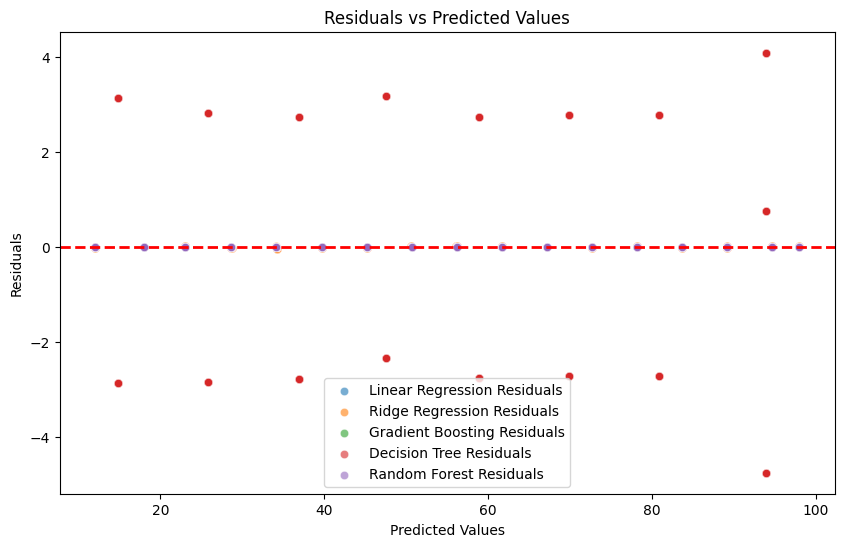

In [43]:
model1_preds = pred_dict['Linear Regression'] 
model2_preds = pred_dict['Ridge Regression'] 
model3_preds = pred_dict['Gradient Boosting']
model4_preds = pred_dict['Decision Tree']
model5_preds = pred_dict['Random Forest']

model_names = ['Linear Regression', 'Ridge Regression', 'Gradient Boosting', 'Decision Tree', 'Random Forest']

plot_residuals_vs_predictions([model1_preds, model2_preds, model3_preds, model4_preds, model5_preds], y_test, model_names)

* **Plot de Resíduos vs Valores Preditos (plot_residuals_vs_predictions)**



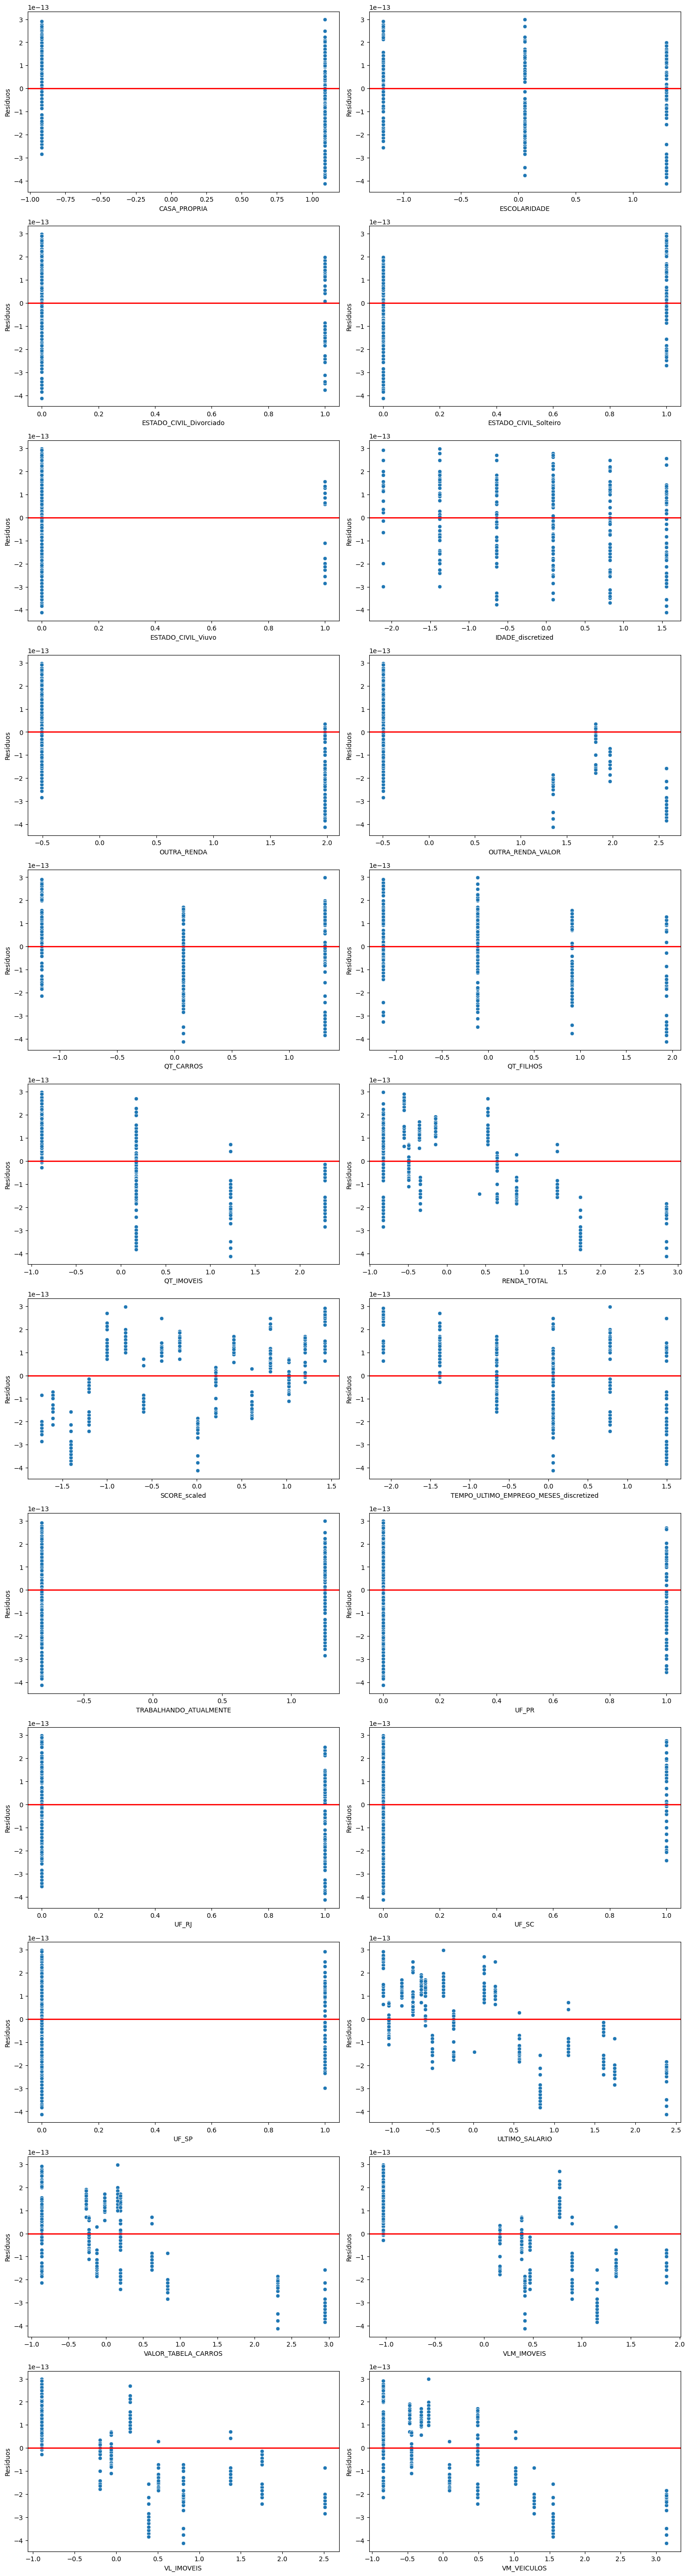

In [44]:
plot_residuals_vs_features(X_test_scaled, y_test, pred_dict['Linear Regression'])

* **Plot da Distribuição dos Resíduos (plot_residuals_distribution)**

Este gráfico fornece uma visualização da distribuição dos resíduos. A normalidade dos resíduos é uma suposição importante em muitos modelos de regressão, especialmente na regressão linear.
Se os resíduos não seguem uma distribuição normal, isso pode indicar que o modelo não está adequadamente ajustado.


A distribuição também pode mostrar a presença de outliers (valores extremos), que podem influenciar o modelo e as previsões. Isso pode ter um impacto para o negócio, pois outliers podem representar casos especiais que exigem atenção adicional.


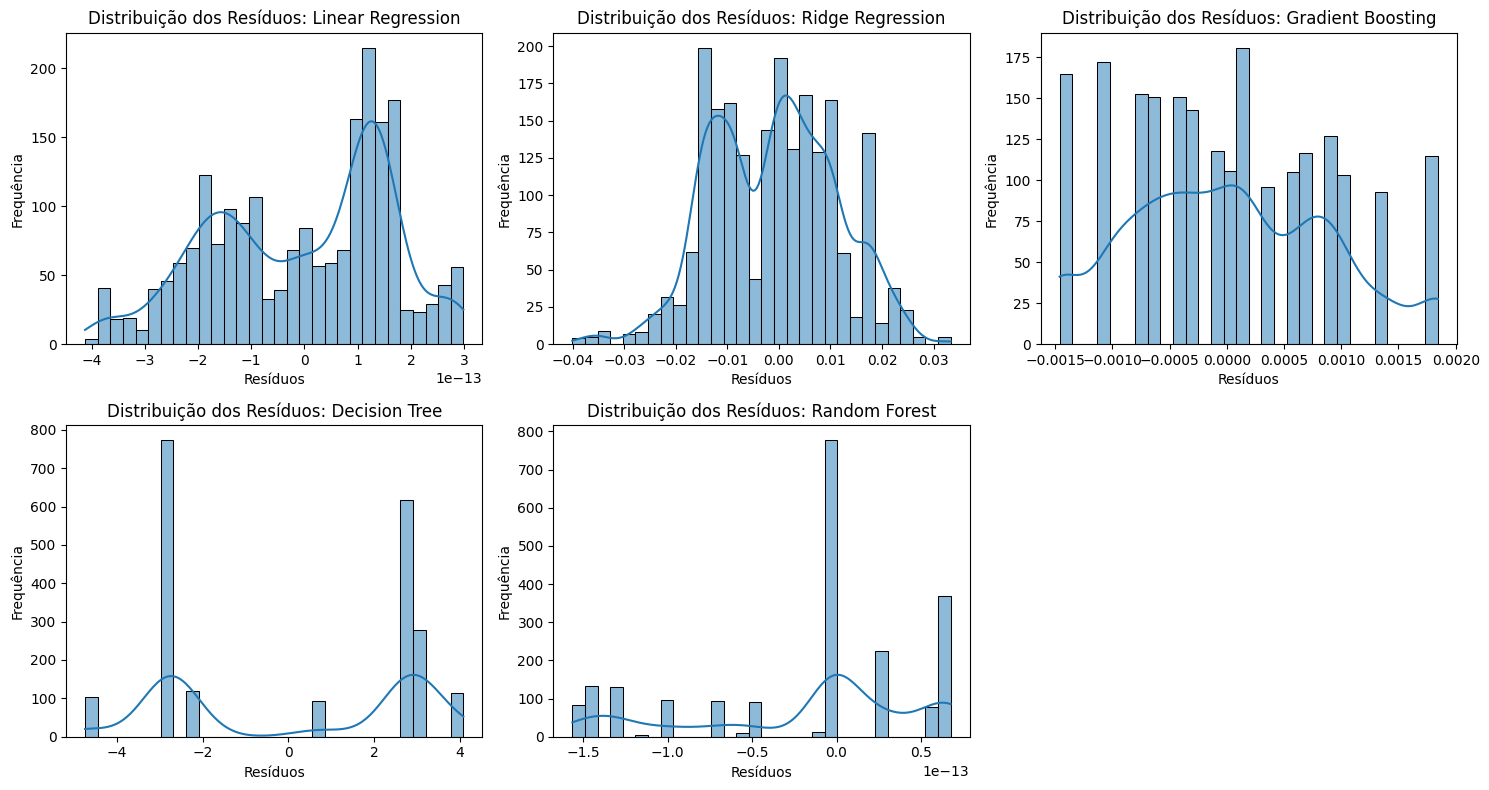

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_residuals_distribution(residuals, ax):
    """
    Plota a distribuição dos resíduos.

    Parâmetros:
    - residuals: Resíduos do modelo (y_true - y_pred).
    - ax: Eixo do matplotlib onde o gráfico será plotado.
    """
    sns.histplot(residuals, kde=True, bins=30, ax=ax)
    ax.set_title('Distribuição dos Resíduos')
    ax.set_xlabel('Resíduos')
    ax.set_ylabel('Frequência')

# Criar uma figura com subplots
plt.figure(figsize=(15, 8))

pred_dict = {
     'Linear Regression': model1_preds,
     'Ridge Regression': model2_preds,
     'Gradient Boosting': model3_preds,
     'Decision Tree': model4_preds,
     'Random Forest': model5_preds
 }

# Loop para plotar a distribuição dos resíduos de cada modelo
for i, model_name in enumerate(model_names):
    residuals = y_test - pred_dict[model_name]  # Calcular os resíduos para o modelo atual
    ax = plt.subplot(2, 3, i + 1)  # 2 linhas, 3 colunas
    plot_residuals_distribution(residuals, ax)  # Chamar a função de plotagem com o eixo
    ax.set_title(f'Distribuição dos Resíduos: {model_name}')  # Título do subplot

plt.tight_layout()  
plt.show()

* **Plot de Valores Reais vs Valores Preditos (plot_real_vs_predicted)**

Avaliação da Performance do Modelo: Este gráfico ajuda a visualizar o quão próximo as previsões estão dos valores reais. Um modelo ideal teria todos os pontos próximos à linha diagonal, indicando previsões precisas.
Identificação de Erros: Erros sistemáticos podem ser identificados facilmente. Por exemplo, se os pontos tendem a ficar acima ou abaixo da linha diagonal, isso indica que o modelo tem uma tendência a superestimar ou subestimar as previsões, o que pode impactar decisões de negócios.

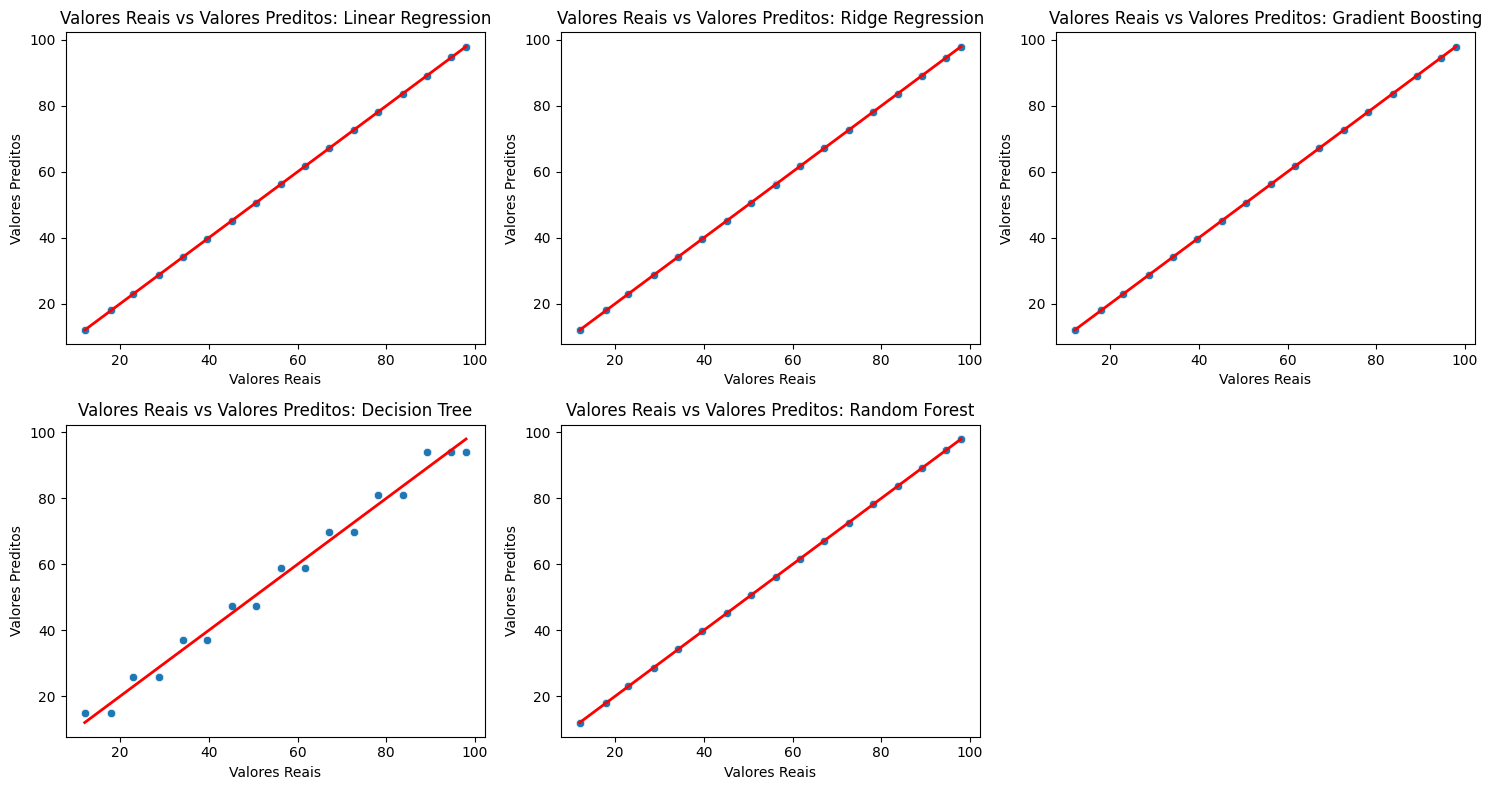

In [53]:
def plot_real_vs_predicted(y_true, y_pred, ax):
    """
    Plota os valores reais em relação aos valores preditos.

    Parâmetros:
    - y_true: Valores reais do target.
    - y_pred: Valores preditos do modelo.
    - ax: Eixo do matplotlib onde o gráfico será plotado.
    """
    sns.scatterplot(x=y_true, y=y_pred, ax=ax)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
    ax.set_xlabel('Valores Reais')
    ax.set_ylabel('Valores Preditos')
    ax.set_title('Valores Reais vs Valores Preditos')

# Criar uma figura com subplots
plt.figure(figsize=(15, 8))

# Loop para plotar valores reais vs preditos de cada modelo
for i, model_name in enumerate(model_names):
    y_pred = pred_dict[model_name]  # Obter as predições do modelo atual
    ax = plt.subplot(2, 3, i + 1)  # 2 linhas, 3 colunas
    plot_real_vs_predicted(y_test, y_pred, ax)  # Chamar a função de plotagem com o eixo
    ax.set_title(f'Valores Reais vs Valores Preditos: {model_name}')  # Título do subplot

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()


* **Plot da Distribuição dos Erros Absolutos (plot_absolute_errors)**
Significado para o Negócio e os Dados:

Análise da Magnitude dos Erros: Esse gráfico fornece insights sobre a magnitude dos erros absolutos, permitindo que se entenda melhor quão longe as previsões estão dos valores reais em média. Isso é crucial para entender o impacto financeiro de decisões baseadas em previsões.
Identificação de Erros Críticos: Um entendimento claro da distribuição dos erros absolutos pode ajudar na identificação de casos em que as previsões são particularmente ruins, ajudando a equipe a focar na melhoria do modelo para esses casos.

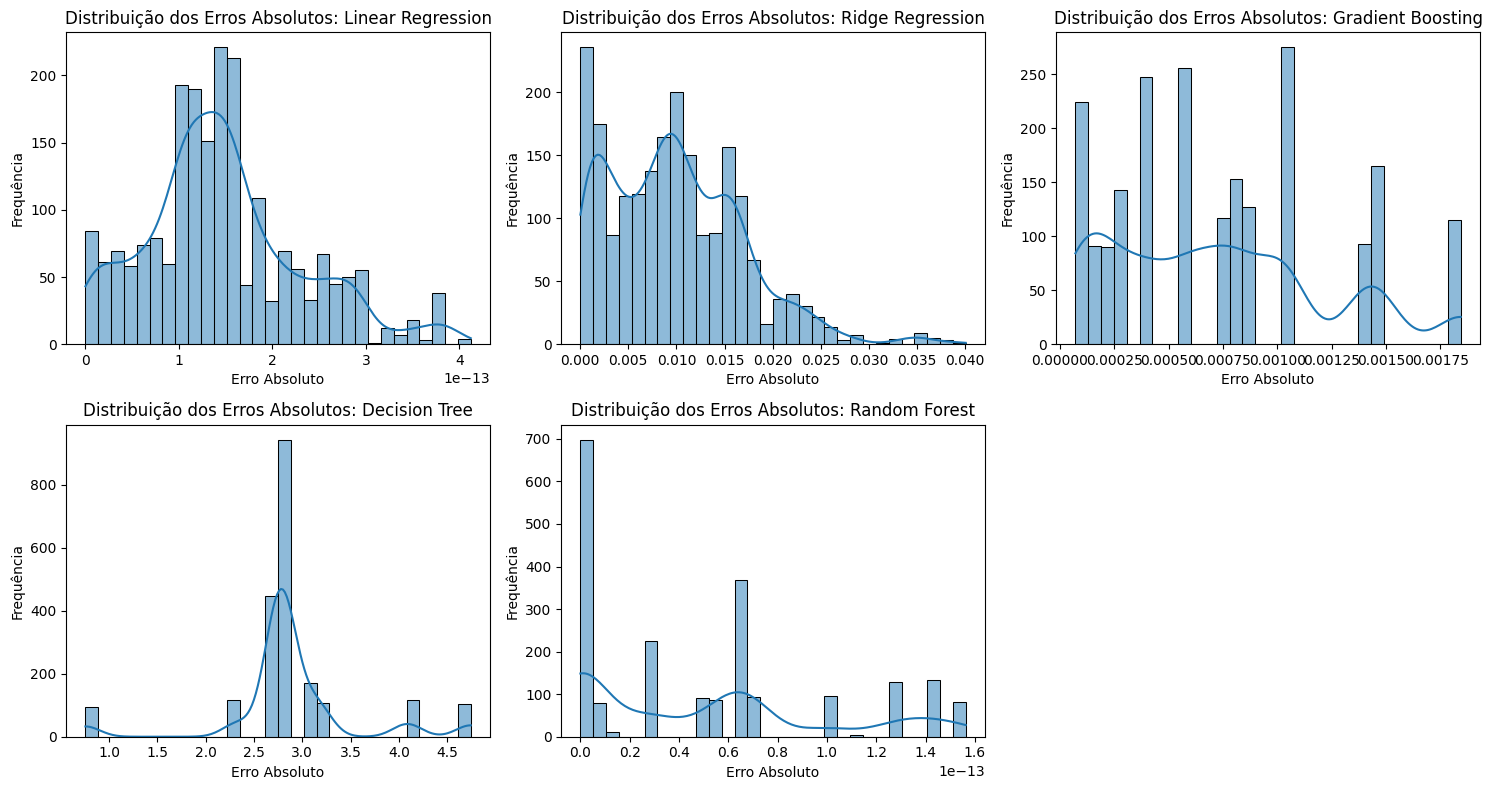

In [54]:
def plot_absolute_errors(y_true, y_pred, ax):
    """
    Plota a distribuição dos erros absolutos.

    Parâmetros:
    - y_true: Valores reais do target.
    - y_pred: Valores preditos do modelo.
    - ax: Eixo do matplotlib onde o gráfico será plotado.
    """
    residuals = y_true - y_pred
    absolute_errors = abs(residuals)
    sns.histplot(absolute_errors, kde=True, bins=30, ax=ax)
    ax.set_title('Distribuição dos Erros Absolutos')
    ax.set_xlabel('Erro Absoluto')
    ax.set_ylabel('Frequência')

# Criar uma figura com subplots
plt.figure(figsize=(15, 8))

# Loop para plotar a distribuição dos erros absolutos de cada modelo
for i, model_name in enumerate(model_names):
    y_pred = pred_dict[model_name]  # Obter as predições do modelo atual
    ax = plt.subplot(2, 3, i + 1)  # 2 linhas, 3 colunas
    plot_absolute_errors(y_test, y_pred, ax)  # Chamar a função de plotagem com o eixo
    ax.set_title(f'Distribuição dos Erros Absolutos: {model_name}')  # Título do subplot

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

## Feature Importance

Feature Importance refere-se à medida que quantifica o impacto de cada variável em um modelo de machine learning, indicando quais atributos têm maior influência nas previsões. Ela é utilizada para identificar as variáveis mais relevantes para a precisão do modelo, auxiliando na otimização dos dados e decisões sobre quais informações coletar ou refinar.

Em um contexto de análise de regressão para _credit score_, a _feature importance_ pode revelar quais fatores (como renda, histórico de pagamento ou idade) têm maior peso na determinação do score final. Isso pode ser útil para instituições financeiras, permitindo foco em dados mais relevantes ao prever a capacidade de crédito de um cliente.

____________________________________________________________________________________________________________________________________
Existem algumas mtécnicas para identificar a importância dessas características, as duas mais conhecidas são o LIME (Local Interpretable Model-agnostic Explanations) e o SHAP (Shapley Additive Explanations). Elas são amplamente utilizadas no ambiente de negócios, pois facilitam a tomada de decisões mais informadas e transparentes, especialmente em setores regulados, como o financeiro.

* **LIME (Local Interpretable Model-agnostic Explanations)**
O LIME é uma abordagem que visa explicar o comportamento do modelo em torno de uma instância específica, ou seja, ele busca fornecer uma explicação local de como o modelo chegou a uma previsão individual. A técnica ajusta um modelo linear simples ao redor de uma previsão específica, ajudando a identificar as variáveis mais importantes para aquela previsão.

Características principais:
Localidade: O LIME se concentra em prever uma única instância. Ele constrói um modelo explicativo ao redor de um ponto específico no espaço de dados, oferecendo uma explicação simplificada para aquela previsão.
Modelo-agnóstico: Essa técnica pode ser aplicada a qualquer tipo de modelo, seja ele uma rede neural, uma árvore de decisão, ou qualquer outro algoritmo.
Interpretação simplificada: Como utiliza um modelo linear simples para explicar a previsão, o LIME oferece uma visão clara de como as variáveis influenciaram a saída.
Aplicação em Score de Crédito:
Suponha que o modelo preveja um score de crédito para um cliente específico. O LIME pode explicar por que aquele cliente obteve determinado score. No caso, pode apontar que o score foi alto devido a fatores como a renda do cliente e seu histórico de pagamentos. Essa abordagem é muito útil quando a empresa deseja entender a previsão em um nível individual e tomar ações mais direcionadas.

* **SHAP (Shapley Additive Explanations)** 
O SHAP, por outro lado, baseia-se na teoria dos jogos e oferece uma interpretação mais profunda e consistente. Ele atribui um valor a cada variável, indicando sua contribuição exata para a previsão de uma instância específica. O grande diferencial do SHAP é que ele considera todas as combinações possíveis de variáveis e calcula de maneira equitativa a importância de cada uma, garantindo consistência e interpretabilidade tanto global quanto local.

Características principais:
Consistência global e local: O SHAP não só explica a previsão para uma instância específica, mas também fornece uma visão global de como cada variável afeta todas as previsões do modelo.
Justiça matemática: Baseado em teoria dos jogos, o SHAP garante que as variáveis mais importantes sempre terão os valores de importância mais altos.
Robustez e precisão: Ao calcular a contribuição de todas as combinações possíveis de variáveis, o SHAP oferece uma explicação mais precisa e teoricamente fundamentada.
Aplicação em Score de Crédito:
Ao aplicar o SHAP em um modelo de score de crédito, pode-se entender não apenas por que um cliente específico recebeu um score, mas também como cada variável (idade, renda, histórico de pagamento, etc.) impacta as previsões para todos os clientes. Isso permite uma análise detalhada de como o modelo utiliza as variáveis, oferecendo explicações transparentes para stakeholders.

Comparação entre LIME e SHAP:
Abordagem: LIME foca em explicações locais e simplificadas, ajustando um modelo linear ao redor de uma previsão específica. Já o SHAP utiliza uma decomposição mais detalhada e teórica, explicando tanto previsões individuais quanto a importância geral das variáveis.
Cálculo: O SHAP é mais robusto em termos matemáticos, pois considera todas as combinações possíveis de variáveis, enquanto o LIME faz aproximações simplificadas.
Interpretação: LIME é mais rápido e prático, ideal para explicações rápidas e diretas. No entanto, o SHAP oferece maior precisão e consistência, sendo a melhor escolha quando a transparência e a equidade são essenciais.

In [ ]:
import matplotlib.pyplot as plt
import shap
import numpy as np
from sklearn.inspection import permutation_importance

def plot_permutation_importance(X_test, y_test, model, feature_names):
    """
    Plota a importância das variáveis usando permutação.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - y_test: Dados de teste para o target.
    - model: Modelo treinado.
    - feature_names: Lista com os nomes das variáveis/features.
    """
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
    importances = result.importances_mean
    std = result.importances_std
    indices = np.argsort(importances)[::-1]  # Ordenar pela importância

    plt.figure(figsize=(12, 8))
    plt.title("Feature Importance - Permutation")
    plt.barh(range(len(importances)), importances[indices], xerr=std[indices], align="center")
    plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.xlabel("Mean Importance")
    plt.gca().invert_yaxis()  # Inverter para ter a maior importância no topo
    plt.show()

def plot_lime_importance(X_test, model, lime_explainer, instance_idx=0):
    """
    Plota a importância das variáveis usando LIME.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - model: Modelo treinado.
    - lime_explainer: Explicador LIME.
    - instance_idx: Índice da instância de teste a ser explicada.
    """
    explanation = lime_explainer.explain_instance(X_test[instance_idx], model.predict)
    feature_importances = np.array([x[1] for x in explanation.as_list()])
    features = np.array([x[0] for x in explanation.as_list()])

    plt.figure(figsize=(12, 8))
    plt.title(f"Feature Importance - LIME (Instance {instance_idx})")
    plt.barh(features, feature_importances, align="center")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.show()

def plot_shap_importance(X_test, model):
    """
    Plota a importância das variáveis usando SHAP.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - model: Modelo treinado.
    """
    explainer = shap.Explainer(model, X_test)
    shap_values = explainer(X_test)

    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    plt.title("Feature Importance - SHAP")
    plt.show()

def plot_feature_importances(X_test, y_test, model, feature_names, explainer_type='permutation', lime_explainer=None, instance_idx=0):
    """
    Plota a importância das variáveis usando permutação, LIME ou SHAP.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - y_test: Dados de teste para o target.
    - model: Modelo treinado.
    - feature_names: Lista com os nomes das variáveis/features.
    - explainer_type: Tipo de explicador a ser usado ('permutation', 'lime' ou 'shap').
    - lime_explainer: Explicador LIME (necessário se for escolhido 'lime').
    - instance_idx: Índice da instância de teste a ser explicada pelo LIME (se aplicável).
    """
    if explainer_type == 'permutation':
        plot_permutation_importance(X_test, y_test, model, feature_names)

    elif explainer_type == 'lime':
        if lime_explainer is None:
            raise ValueError("LIME explainer must be provided for explainer_type='lime'.")
        plot_lime_importance(X_test, model, lime_explainer, instance_idx)

    elif explainer_type == 'shap':
        plot_shap_importance(X_test, model)

    else:
        raise ValueError("Invalid explainer_type. Choose 'permutation', 'lime', or 'shap'.")


# Run Models

## Features Analysis

ModuleNotFoundError: No module named 'shap'

In [141]:
plot_feature_importances(X_test_scaled, y_test, model, feature_names, explainer_type='permutation')


NameError: name 'plot_feature_importances' is not defined

In [135]:
pred_dict

{'Linear Regression': array([52.7768892 , 52.77182619, 46.76297839, ..., 54.58849269,
        88.38561049, 82.94736162]),
 'Ridge Regression': array([51.74593686, 51.75460204, 47.37719574, ..., 54.93634457,
        88.38433775, 83.5644614 ]),
 'Gradient Boosting': array([39.66275676, 39.66275676, 56.16733506, ..., 34.1728689 ,
        83.66738569, 89.16481717]),
 'Decision Tree': array([45.45535251, 45.45535251, 58.92030905, ..., 45.45535251,
        83.66666667, 93.91142098]),
 'Random Forest': array([36.93215888, 36.93215888, 56.16666667, ..., 36.93215888,
        83.66666667, 89.16666667])}

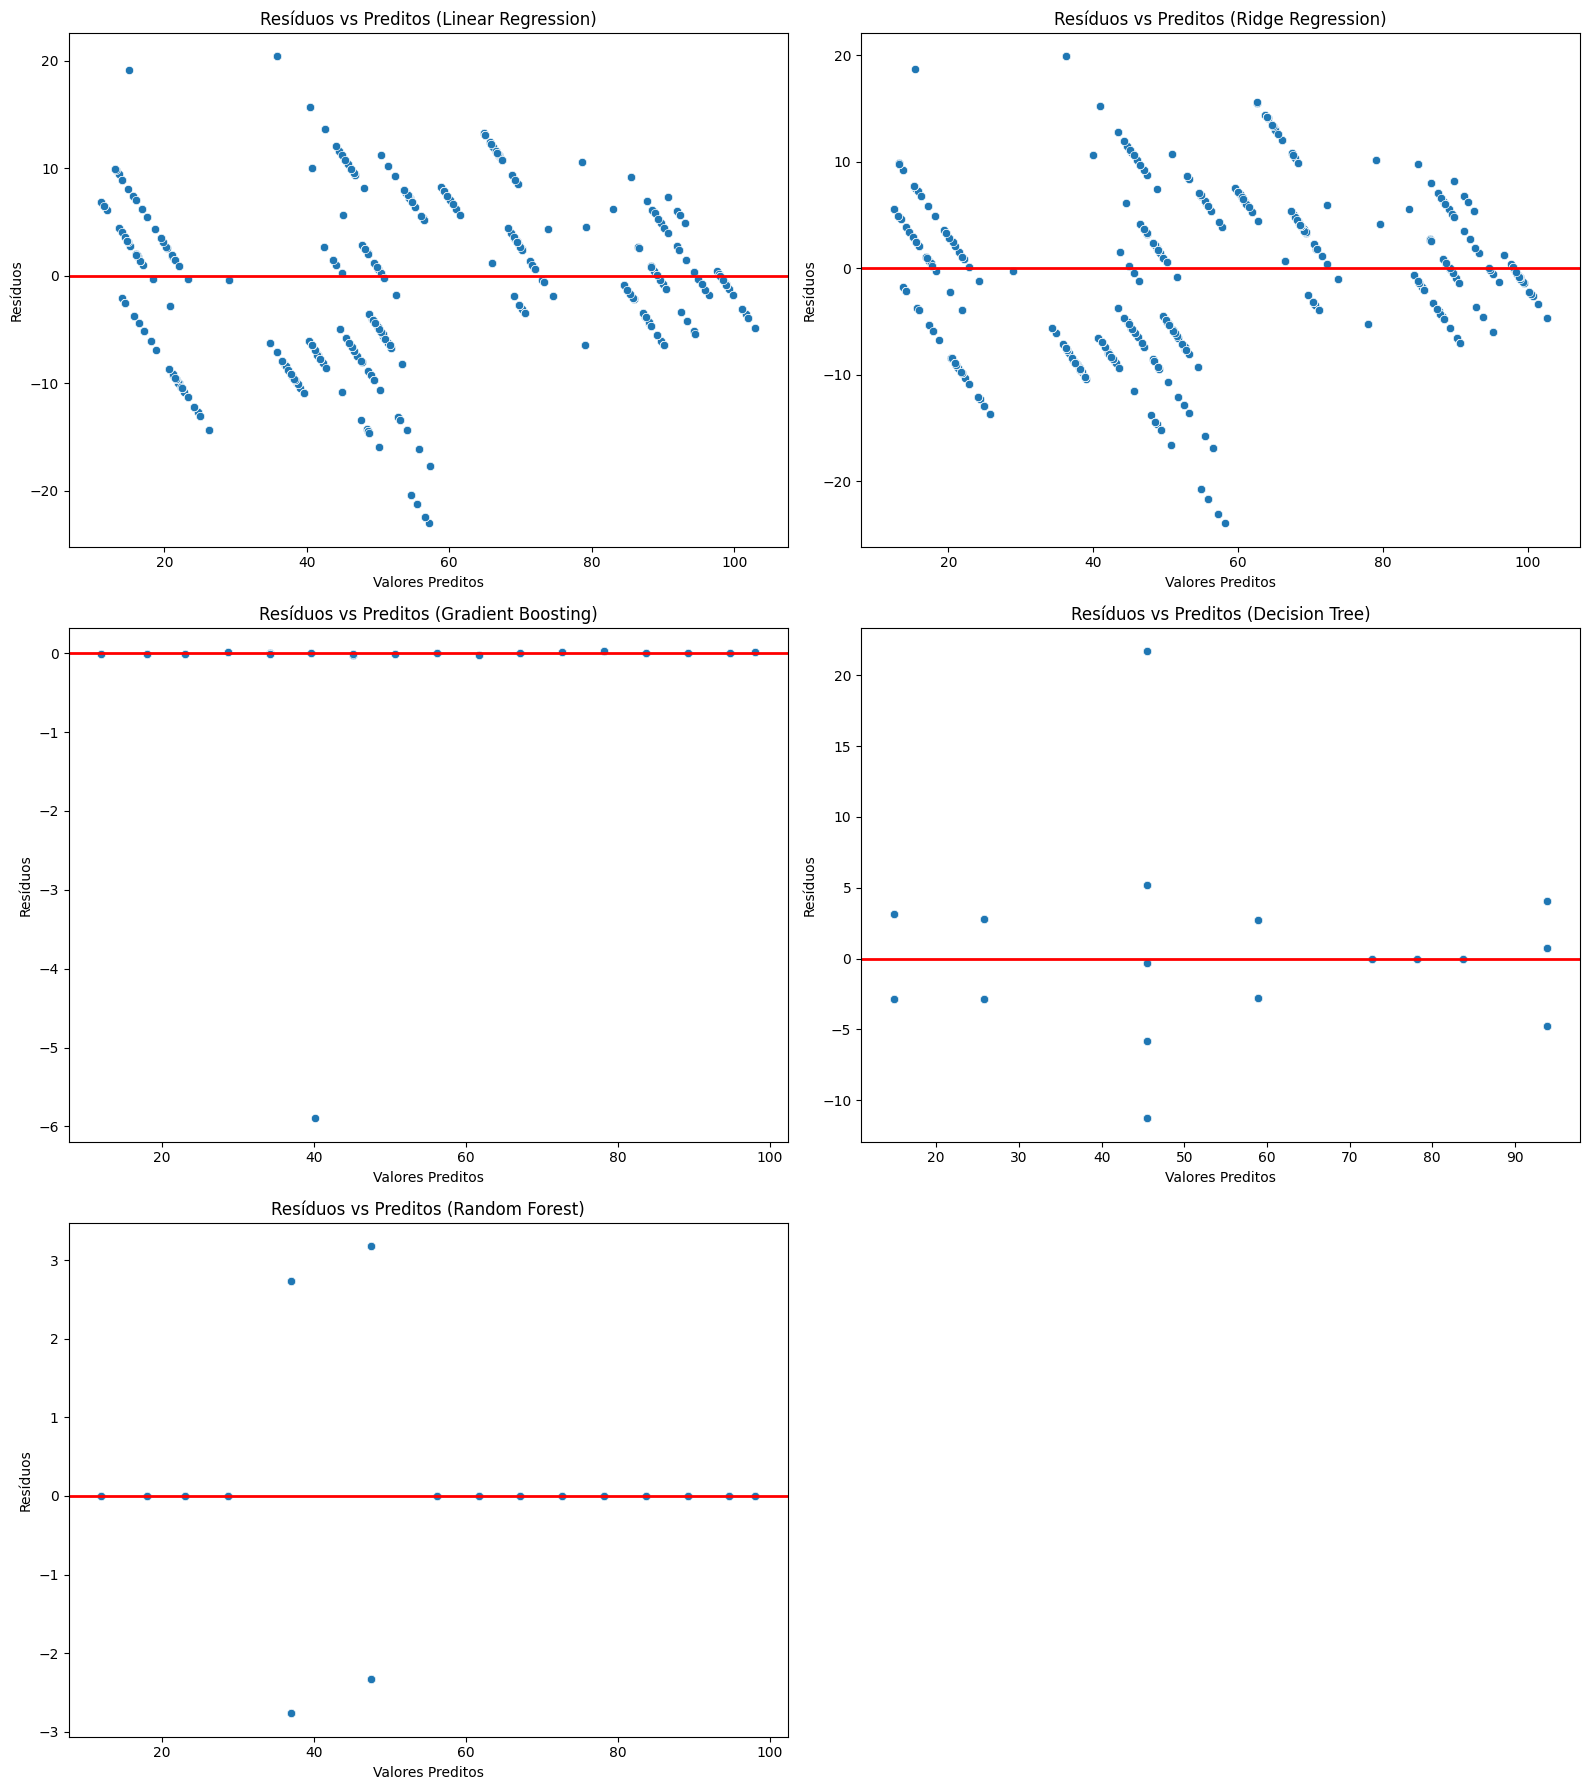

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_model_residuals(X_test, y_test, models_dict):
    """
    Plota os resíduos de cada modelo em um grid de subplots, ajustando automaticamente o layout.
    
    Parâmetros:
    - X_test: Features de teste
    - y_test: Target de teste
    - models_dict: Dicionário contendo o nome do modelo e a instância
    """
    num_models = len(models_dict)
    
    # Definir o número de colunas (2 fixas) e calcular o número de linhas necessárias
    num_cols = 2
    num_rows = math.ceil(num_models / num_cols)  # Arredondar para cima o número de linhas
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 6))  # Ajusta o tamanho com base nas linhas
    axes = axes.ravel()  # Flatten a matriz de axes para fácil iteração

    for idx, (name, model) in enumerate(models_dict.items()):
        # Fazer as previsões para o modelo
        y_pred = model.predict(X_test)
        
        # Calcular os resíduos
        residuals = y_test - y_pred
        
        # Plotar no eixo correspondente
        sns.scatterplot(x=y_pred, y=residuals, ax=axes[idx])
        axes[idx].axhline(0, color='red', lw=2)  # Linha no eixo Y = 0
        axes[idx].set_title(f'Resíduos vs Preditos ({name})')
        axes[idx].set_xlabel('Valores Preditos')
        axes[idx].set_ylabel('Resíduos')

    # Remover os subplots vazios (se houver)
    for idx in range(num_models, len(axes)):
        fig.delaxes(axes[idx])

    # Ajustar o layout
    plt.tight_layout()
    plt.show()

plot_model_residuals(X_test_scaled, y_test, models)


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import shap
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer

def plot_feature_importances(X_test, y_test, model, feature_names, explainer_type='permutation', lime_explainer=None):
    """
    Plota a importância das variáveis usando permutação, LIME ou SHAP.
    
    Parâmetros:
    - X_test: Dados de teste para as features.
    - y_test: Dados de teste para o target.
    - model: Modelo treinado.
    - feature_names: Lista com os nomes das variáveis/features.
    - explainer_type: Tipo de explicador a ser usado ('permutation', 'lime' ou 'shap').
    - lime_explainer: Explicador LIME (se aplicável).
    """
    plt.figure(figsize=(12, 8))
    
    if explainer_type == 'permutation':
        # Calcule a importância por permutação
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)
        importances = result.importances_mean
        std = result.importances_std
        indices = importances.argsort()
        plt.title("Importância das Variáveis - Permutação")
        plt.barh(range(len(importances)), importances[indices], xerr=std[indices], align="center")
        plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
        plt.xlabel("Importância Média")
    
    elif explainer_type == 'lime':
        # Verifique se o explicador LIME foi fornecido
        if lime_explainer is None:
            raise ValueError("Explicador LIME deve ser fornecido para o tipo de explicador 'lime'.")
        # Explique a previsão do modelo usando LIME
        explanation = lime_explainer.explain_instance(X_test[0], model.predict_proba)
        feature_importances = np.array([x[1] for x in explanation.as_list()])
        features = np.array([x[0] for x in explanation.as_list()])
        plt.title("Importância das Variáveis - LIME")
        plt.barh(features, feature_importances, align="center")
        plt.xlabel("Importância")
    
    elif explainer_type == 'shap':
        # Calcule a importância usando SHAP
        explainer = shap.Explainer(model, X_test)
        shap_values = explainer(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar")
        plt.title("Importância das Variáveis - SHAP")
    
    else:
        raise ValueError("Tipo de explicador inválido. Escolha 'permutation', 'lime' ou 'shap'.")
    
    plt.show()

# Exemplo de uso com cada tipo de explicador
# Crie um explicador LIME (necessário para o tipo 'lime')
lime_explainer = LimeTabularExplainer(X_test.values, feature_names=X_test_scaled.columns, mode='classification')

# Exemplo com permutação
plot_feature_importances(X_test, y_test, model_linear, feature_names, explainer_type='permutation')

# Exemplo com LIME
plot_feature_importances(X_test, y_test, model_linear, feature_names, explainer_type='lime', lime_explainer=lime_explainer)

# Exemplo com SHAP
plot_feature_importances(X_test, y_test, model_linear, feature_names, explainer_type='shap')


ModuleNotFoundError: No module named 'shap'

: 

In [161]:
def regression_metrics(name_model, y_true, y_pred):
    """
    Calcula e retorna as principais métricas de regressão linear.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: DataFrame com as métricas
    """
    # Cálculo das métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    
    # Criação do DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'metrics': ['MAE', 'MSE', 'RMSE', 'R²'],
        'value_metrics': [mae, mse, rmse, r2]
    })
    
    metrics_df['name_model'] = name_model

    return metrics_df

def plot_residuals_vs_predictions(y_true, y_pred):
    """
    Plota os resíduos vs os valores preditos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', lw=2)
    plt.xlabel('Valores Preditos')
    plt.ylabel('Resíduos')
    plt.title('Resíduos vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_residuals_distribution(residuals):
    """
    Plota a distribuição dos resíduos.
    
    :param residuals: Resíduos (diferença entre valores reais e preditos)
    :return: Figura com o gráfico
    """
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title('Distribuição dos Resíduos')
    plt.xlabel('Resíduos')
    plt.show()
    return plt.gcf()

def plot_real_vs_predicted(y_true, y_pred):
    """
    Plota os valores reais vs valores preditos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.title('Valores Reais vs Valores Preditos')
    plt.show()
    return plt.gcf()

def plot_absolute_errors(y_true, y_pred):
    """
    Plota a distribuição dos erros absolutos.
    
    :param y_true: Valores reais
    :param y_pred: Valores preditos
    :return: Figura com o gráfico
    """
    residuals = y_true - y_pred
    absolute_errors = abs(residuals)
    plt.figure(figsize=(8, 6))
    sns.histplot(absolute_errors, kde=True, bins=30)
    plt.title('Distribuição dos Erros Absolutos')
    plt.xlabel('Erro Absoluto')
    plt.show()
    return plt.gcf()


: 

In [139]:
def plot_residuals_distribution_all_models(X_test, y_test, models_dict):
    """
    Plota a distribuição dos resíduos de cada modelo em um grid de subplots, ajustando automaticamente o layout.
    
    Parâmetros:
    - X_test: Features de teste
    - y_test: Target de teste
    - models_dict: Dicionário contendo o nome do modelo e a instância
    """
    num_models = len(models_dict)
    
    # Definir o número de colunas (2 fixas) e calcular o número de linhas necessárias
    num_cols = 2
    num_rows = math.ceil(num_models / num_cols)  # Arredondar para cima o número de linhas
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 6))  # Ajusta o tamanho com base nas linhas
    axes = axes.ravel()  # Flatten a matriz de axes para fácil iteração

    for idx, (name, model) in enumerate(models_dict.items()):
        # Fazer as previsões para o modelo
        y_pred = model.predict(X_test)
        
        # Calcular os resíduos
        residuals = y_test - y_pred
        
        # Plotar a distribuição dos resíduos no eixo correspondente
        sns.histplot(residuals, kde=True, ax=axes[idx], bins=30)
        axes[idx].set_title(f'Distribuição dos Resíduos ({name})')
        axes[idx].set_xlabel('Resíduos')
        axes[idx].set_ylabel('Frequência')

    # Remover os subplots vazios (se houver)
    for idx in range(num_models, len(axes)):
        fig.delaxes(axes[idx])

    # Ajustar o layout
    plt.tight_layout()
    plt.show()

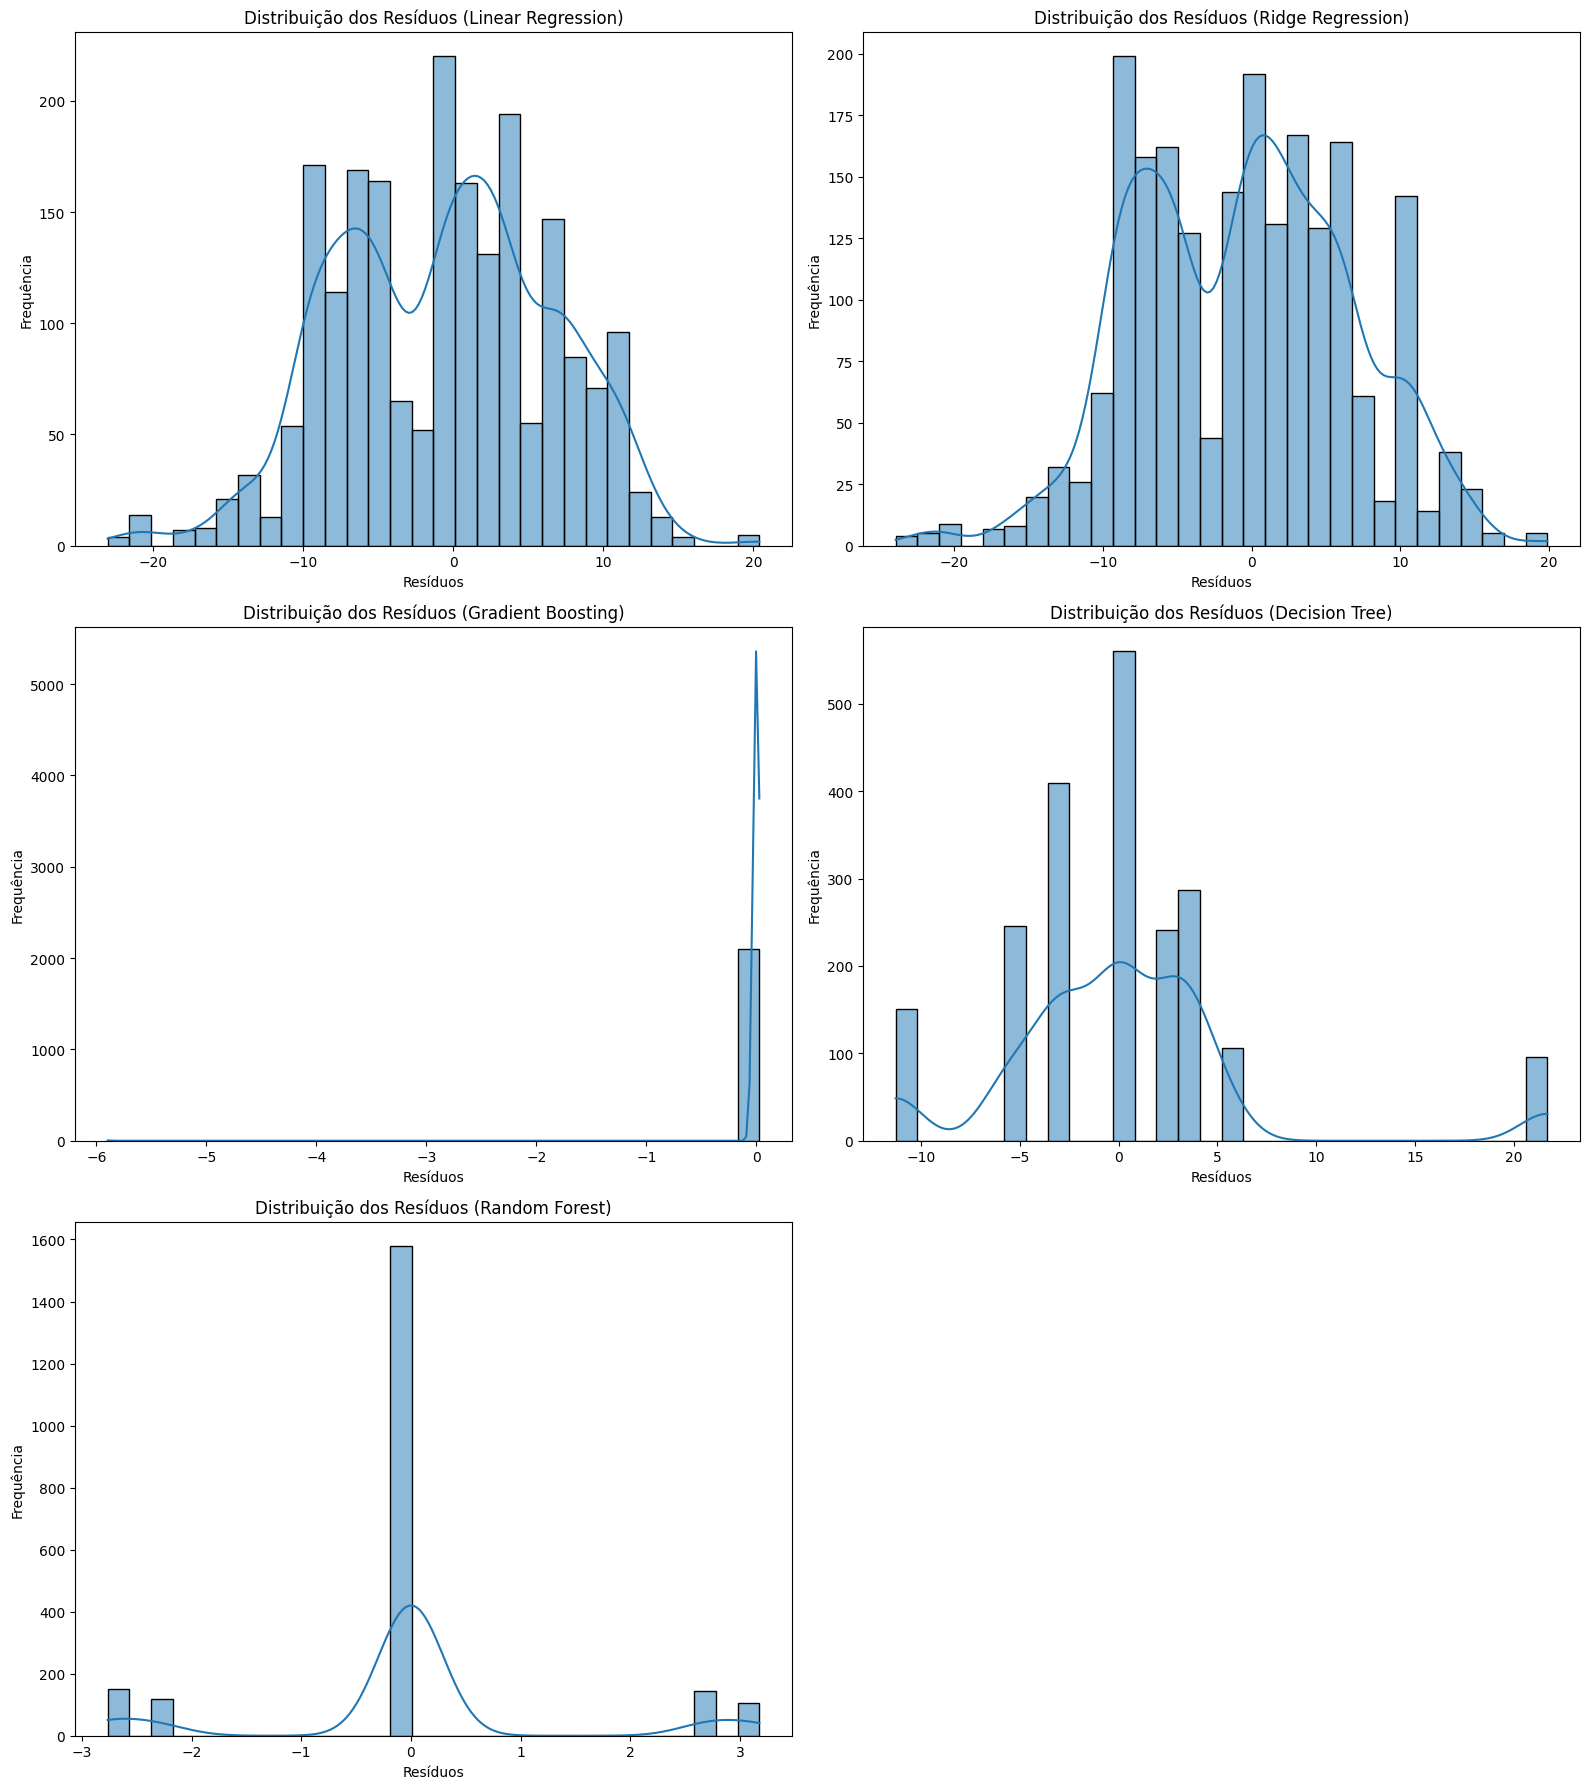

In [140]:
plot_residuals_distribution_all_models(X_test_scaled, y_test, models)

# Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score

# Validação cruzada com 5 folds
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² médio na validação cruzada: {cv_scores.mean()}")


R² médio na validação cruzada: 0.9358954116117013


: 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
degree = 3  # Grau do polinômio
poly_features = PolynomialFeatures(degree=degree)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

# Treinamento do modelo Polinomial
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predição nos dados de teste
y_pred_poly = poly_model.predict(X_test_poly)

# Obtendo as métricas
metrics_df_poly = regression_metrics('polinomial', y_test, y_pred_poly)
print(metrics_df_poly)

  metrics  value_metrics  name_model
0     MAE           0.00  polinomial
1     MSE           0.00  polinomial
2    RMSE           0.00  polinomial
3      R²           1.00  polinomial


: 

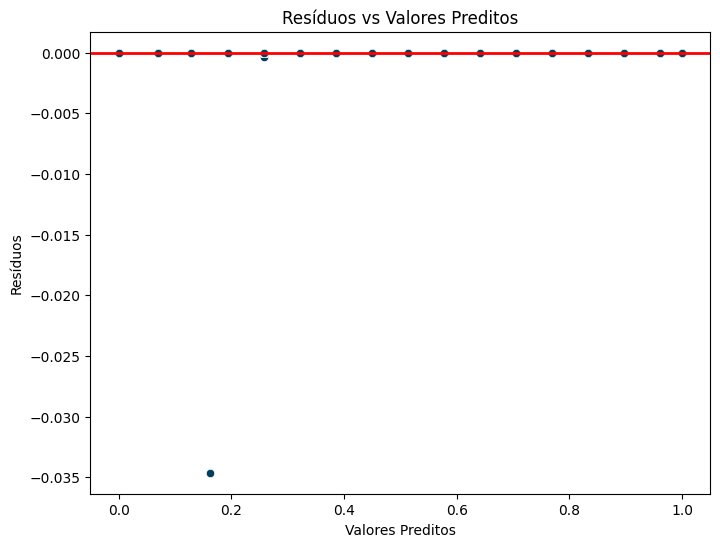

<Figure size 640x480 with 0 Axes>

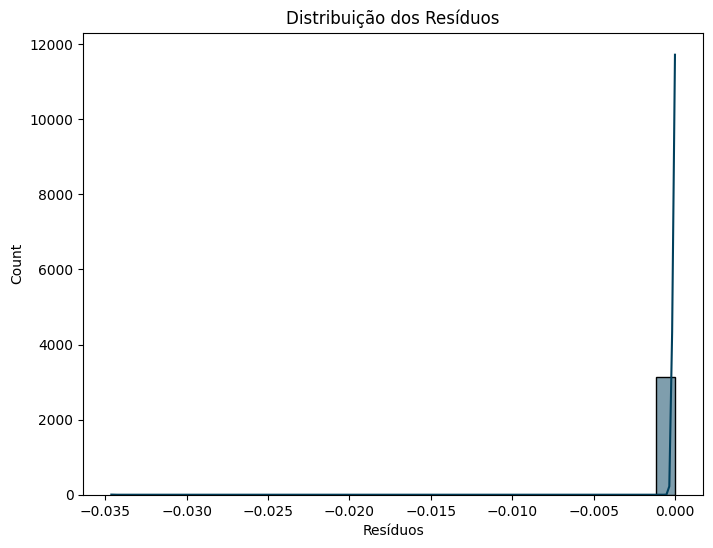

<Figure size 640x480 with 0 Axes>

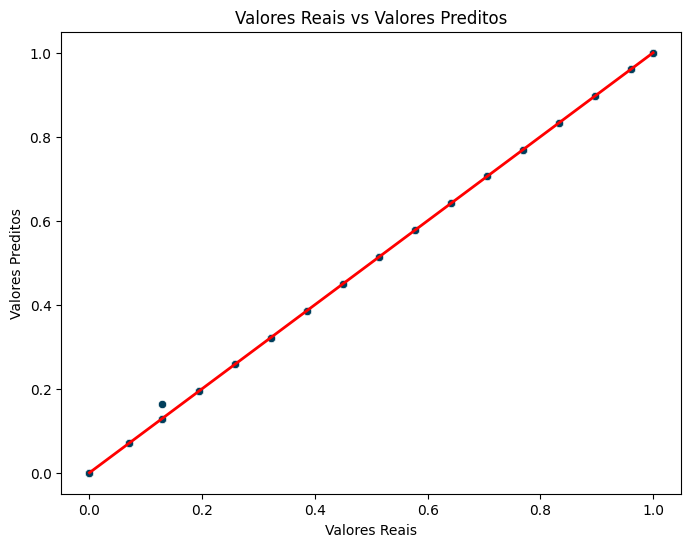

<Figure size 640x480 with 0 Axes>

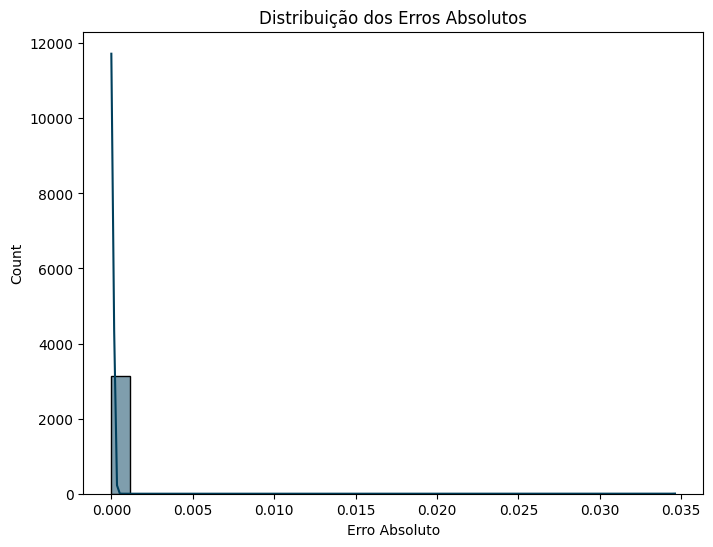

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
plot_residuals_vs_predictions(y_test, y_pred_poly)
plot_residuals_distribution(y_test - y_pred_poly)
plot_real_vs_predicted(y_test, y_pred_poly)
plot_absolute_errors(y_test, y_pred_poly)

: 